In [1]:
import pandas as pd
import itertools
import warnings
import numpy as np
import joblib
from catboost import CatBoostRegressor, Pool
from prophet import Prophet
import json
from prophet.serialize import model_to_json, model_from_json
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from helpers import grid_search_sarima, plot_test, datetime_features
from statsmodels.tools.eval_measures import rmse

In [2]:
traffic_df = pd.read_csv('../traffic.csv')
traffic_df = traffic_df.set_index('Date')
traffic_df.index = pd.to_datetime(traffic_df.index, format='%Y-%m-%d')
traffic_df.head()

,Views
Date,
2015-07-01,912686971
2015-08-01,906581034
2015-09-01,973735682
2015-10-01,1059989545
2015-11-01,1107062550


In [3]:
def create_sarima(train_set, test_set, info=True, display=True, save=False):
    model = grid_search_sarima(train_traffic)
    pred_start_date = test_traffic.index[0]
    pred_end_date = test_traffic.index[-1]
    predictions = model.predict(start=pred_start_date, end=pred_end_date)
    residuals = test_traffic - predictions
    if info:
        sarimax_aic = model.aic
        sarimax_bic = model.bic
        sarimax_mean_squared_error = model.mse
        sarimax_sum_squared_error = model.sse
        print(f'Akaike information criterion | AIC: {sarimax_aic}')
        print(f'Bayesian information criterion | BIC: {sarimax_bic}')
        print(f'Mean Squared Error | MSE: {sarimax_mean_squared_error}')
        print(f'Sum Squared Error | SSE: {sarimax_sum_squared_error}')
    
    if display:
        plot_test(test_set, predictions)
        
    if save:
        joblib.dump(model, '../models/sarima.pkl')    
    return model

In [4]:
def create_catboost(train_features, train_target, test_features, test_target,\
                    info=True, display=True, save=False):
    grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
    model = CatBoostRegressor(custom_metric=['RMSE', 'MAE', 'R2'])#loss_function='RMSE'
    train = Pool(train_traffic_features, train_traffic_target)
    model.grid_search(grid, train)
    
    if info:
        print(model.get_best_score()['learn'])
        
    if display:
        predictions = model.predict(test_features)
        predictions = pd.Series(predictions, index = test_traffic_target.index)
        plot_test(test_target, predictions)
        
    if save:
        model.save_model('../models/catboost')
    return model

In [6]:
def create_prophet(train_set, test_set, info=True, display=True, save=False):
    model = Prophet(interval_width=0.95)
    model.fit(train_set)
    future_dates = model.make_future_dataframe(periods=len(test_set), freq='MS')
    predictions = model.predict(future_dates)['yhat'][-len(test_set):]
    
    if info:
        prophet_rmse_error = rmse(test_set, predictions)
        prophet_mse_error = prophet_rmse_error**2
        mean_value = predictions.mean()
        print(f'MSE Error: {prophet_mse_error}\nRMSE Error: {prophet_rmse_error}\nMean: {mean_value}')
        
    if display:
        predictions = pd.Series(predictions.tolist(), index = test_traffic.index)
        plot_test(test_set, predictions)
        
    if save:
        with open('../models/prophet.json', 'w') as fout:
            fout.write(model_to_json(model))
    return model

In [7]:
train_test_split_ratio = int(len(traffic_df)*0.8)

ARIMA(1, 1, 1)x(0, 1, 0, 12) -> AIC: 2324.2108763502333, BIC:2330.4434886819504,  MSE: 2.8123537663135544e+16
ARIMA(1, 1, 1)x(0, 1, 1, 12) -> AIC: 2325.4656369379118, BIC:2333.7757867135347,  MSE: 2.6357739433230224e+16
ARIMA(1, 1, 1)x(1, 1, 0, 12) -> AIC: 2325.7866766487095, BIC:2334.0968264243324,  MSE: 2.7173047090858576e+16
ARIMA(1, 1, 1)x(1, 1, 1, 12) -> AIC: 2320.4694483567096, BIC:2330.8571355762383,  MSE: 2.3913040244056612e+16
ARIMA(1, 1, 2)x(0, 1, 0, 12) -> AIC: 2327.535698979279, BIC:2335.845848754902,  MSE: 2.782643295122829e+16
ARIMA(1, 1, 2)x(0, 1, 1, 12) -> AIC: 2329.1508260536334, BIC:2339.538513273162,  MSE: 2.669555516570498e+16
ARIMA(1, 1, 2)x(1, 1, 0, 12) -> AIC: 2329.311623866863, BIC:2339.699311086392,  MSE: 2.719598082027756e+16
ARIMA(1, 1, 2)x(1, 1, 1, 12) -> AIC: 2322.900546405939, BIC:2335.3657710693733,  MSE: 2.3743905511369172e+16
ARIMA(2, 1, 1)x(0, 1, 0, 12) -> AIC: 2331.5377386900927, BIC:2339.8478884657156,  MSE: 2.793502274864107e+16
ARIMA(2, 1, 1)x(0, 1

C:\Users\79279\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


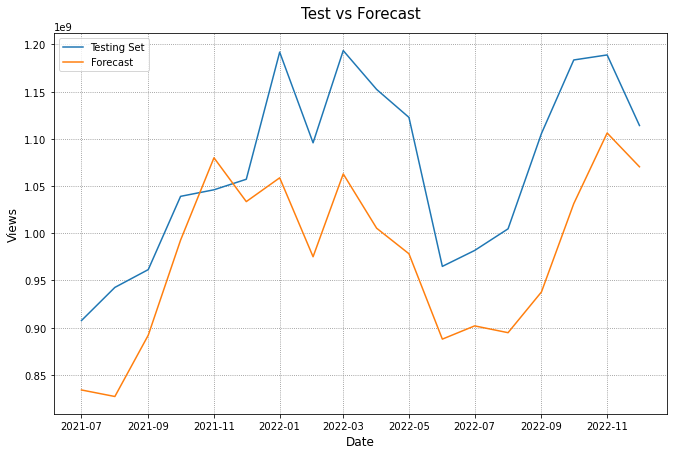

In [8]:
#train SARIMA
train_traffic, test_traffic = traffic_df[:train_test_split_ratio],\
                              traffic_df[train_test_split_ratio:]
create_sarima(train_traffic, test_traffic, save=True)

D:\notebook\Web_Traffic_Forecasting — копия\helpers.py:58: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_temp['weekofyear'] = df_temp.index.weekofyear


0:	learn: 975676977.4805651	test: 1030202099.0265299	best: 1030202099.0265299 (0)	total: 145ms	remaining: 14.4s
1:	learn: 947066240.5460013	test: 1001611108.9075160	best: 1001611108.9075160 (1)	total: 146ms	remaining: 7.16s
2:	learn: 919294680.0091078	test: 973068549.5176333	best: 973068549.5176333 (2)	total: 148ms	remaining: 4.77s
3:	learn: 892317550.8878738	test: 945890273.5910655	best: 945890273.5910655 (3)	total: 149ms	remaining: 3.57s
4:	learn: 866103707.3393202	test: 921135716.3971168	best: 921135716.3971168 (4)	total: 150ms	remaining: 2.85s
5:	learn: 840756136.0730480	test: 895826368.1007395	best: 895826368.1007395 (5)	total: 151ms	remaining: 2.37s
6:	learn: 816102934.1328076	test: 872622389.1816655	best: 872622389.1816655 (6)	total: 152ms	remaining: 2.02s
7:	learn: 792252517.0808957	test: 848863688.2723902	best: 848863688.2723902 (7)	total: 153ms	remaining: 1.76s
8:	learn: 769131441.6411928	test: 825518013.7034264	best: 825518013.7034264 (8)	total: 154ms	remaining: 1.56s
9:	lea

77:	learn: 40412106.7425019	test: 54958978.4989417	best: 54958978.4989417 (77)	total: 60ms	remaining: 16.9ms
78:	learn: 40037824.7659265	test: 55161741.9167107	best: 54958978.4989417 (77)	total: 60.9ms	remaining: 16.2ms
79:	learn: 39633509.6600317	test: 55304586.7818983	best: 54958978.4989417 (77)	total: 61.7ms	remaining: 15.4ms
80:	learn: 39306096.2869885	test: 55338290.3128280	best: 54958978.4989417 (77)	total: 62.6ms	remaining: 14.7ms
81:	learn: 39132854.9549151	test: 55119630.8285646	best: 54958978.4989417 (77)	total: 63.6ms	remaining: 14ms
82:	learn: 38841605.4540583	test: 54666720.7761583	best: 54666720.7761583 (82)	total: 64.5ms	remaining: 13.2ms
83:	learn: 38515261.5549550	test: 54866866.7301619	best: 54666720.7761583 (82)	total: 65.3ms	remaining: 12.4ms
84:	learn: 38152436.7098760	test: 55047287.8951599	best: 54666720.7761583 (82)	total: 66.5ms	remaining: 11.7ms
85:	learn: 37912817.8841178	test: 54821675.6212965	best: 54666720.7761583 (82)	total: 67.3ms	remaining: 11ms
86:	lea

62:	learn: 47014202.5415757	test: 59301514.4312594	best: 59301514.4312594 (62)	total: 46.9ms	remaining: 27.5ms
63:	learn: 46585871.3809666	test: 58692153.4663767	best: 58692153.4663767 (63)	total: 47.8ms	remaining: 26.9ms
64:	learn: 46207363.8945846	test: 58830769.8272976	best: 58692153.4663767 (63)	total: 48.5ms	remaining: 26.1ms
65:	learn: 45829530.6102774	test: 58328837.6076972	best: 58328837.6076972 (65)	total: 49.4ms	remaining: 25.5ms
66:	learn: 45446606.5658507	test: 57778566.2558685	best: 57778566.2558685 (66)	total: 50.3ms	remaining: 24.8ms
67:	learn: 45190496.3801259	test: 57278596.7027396	best: 57278596.7027396 (67)	total: 51.1ms	remaining: 24ms
68:	learn: 44998147.2661306	test: 56954350.4075882	best: 56954350.4075882 (68)	total: 52ms	remaining: 23.3ms
69:	learn: 44634844.5798994	test: 57077823.8111285	best: 56954350.4075882 (68)	total: 52.8ms	remaining: 22.6ms
70:	learn: 44080492.7470509	test: 57188599.3952045	best: 56954350.4075882 (68)	total: 53.7ms	remaining: 21.9ms
71:	l

61:	learn: 49943996.5471307	test: 60020306.6995633	best: 60020306.6995633 (61)	total: 46.5ms	remaining: 28.5ms
62:	learn: 49597330.0350144	test: 59785162.5007572	best: 59785162.5007572 (62)	total: 47.5ms	remaining: 27.9ms
63:	learn: 49201735.0221647	test: 59113079.2829893	best: 59113079.2829893 (63)	total: 48.6ms	remaining: 27.3ms
64:	learn: 48745697.5375195	test: 59169175.0483576	best: 59113079.2829893 (63)	total: 49.7ms	remaining: 26.8ms
65:	learn: 48346354.4969679	test: 59222413.8300828	best: 59113079.2829893 (63)	total: 50.7ms	remaining: 26.1ms
66:	learn: 47973021.9035827	test: 58700241.9229596	best: 58700241.9229596 (66)	total: 51.7ms	remaining: 25.5ms
67:	learn: 47677585.7271019	test: 58654881.8090965	best: 58654881.8090965 (67)	total: 52.7ms	remaining: 24.8ms
68:	learn: 47420961.7713780	test: 58171357.4298885	best: 58171357.4298885 (68)	total: 53.6ms	remaining: 24.1ms
69:	learn: 47042772.6460636	test: 57719492.0850645	best: 57719492.0850645 (69)	total: 54.4ms	remaining: 23.3ms
7

54:	learn: 59976519.4447194	test: 73271543.7487780	best: 73271543.7487780 (54)	total: 39.9ms	remaining: 32.7ms
55:	learn: 59037791.8139671	test: 71911335.0091298	best: 71911335.0091298 (55)	total: 41.1ms	remaining: 32.3ms
56:	learn: 58487348.8697223	test: 70375870.2884575	best: 70375870.2884575 (56)	total: 42.4ms	remaining: 32ms
57:	learn: 57912331.4548482	test: 70137531.1786010	best: 70137531.1786010 (57)	total: 43.3ms	remaining: 31.4ms
58:	learn: 57300577.3655847	test: 69849179.0594070	best: 69849179.0594070 (58)	total: 44.2ms	remaining: 30.7ms
59:	learn: 56687451.9981477	test: 69357147.9413495	best: 69357147.9413495 (59)	total: 45.1ms	remaining: 30.1ms
60:	learn: 56165759.1137369	test: 69144233.6529177	best: 69144233.6529177 (60)	total: 46.1ms	remaining: 29.5ms
61:	learn: 55762289.1480881	test: 69008507.9822646	best: 69008507.9822646 (61)	total: 47ms	remaining: 28.8ms
62:	learn: 55251313.9869013	test: 68645260.8225465	best: 68645260.8225465 (62)	total: 47.8ms	remaining: 28.1ms
63:	l

145:	learn: 58497476.9450925	test: 66450680.6413297	best: 66450680.6413297 (145)	total: 109ms	remaining: 2.98ms
146:	learn: 58200384.6052297	test: 66077872.5380244	best: 66077872.5380244 (146)	total: 110ms	remaining: 2.24ms
147:	learn: 57853130.0438143	test: 65740313.4683228	best: 65740313.4683228 (147)	total: 110ms	remaining: 1.49ms
148:	learn: 57627152.5334767	test: 65176251.8077675	best: 65176251.8077675 (148)	total: 111ms	remaining: 746us
149:	learn: 57402559.4294665	test: 64575836.3912116	best: 64575836.3912116 (149)	total: 112ms	remaining: 0us

bestTest = 64575836.39
bestIteration = 149

8:	loss: 64575836.3912116	best: 53253676.2369851 (5)	total: 1.14s	remaining: 11s
0:	learn: 906941344.1151165	test: 961358175.7196280	best: 961358175.7196280 (0)	total: 563us	remaining: 84ms
1:	learn: 818444834.8488785	test: 872876040.4931427	best: 872876040.4931427 (1)	total: 1.28ms	remaining: 94.4ms
2:	learn: 738695900.0903516	test: 790435012.9629409	best: 790435012.9629409 (2)	total: 2.06ms	rem

29:	learn: 422310829.4568610	test: 475295612.5979969	best: 475295612.5979969 (29)	total: 23.5ms	remaining: 93.9ms
30:	learn: 410577363.6551480	test: 463411884.0005249	best: 463411884.0005249 (30)	total: 24.5ms	remaining: 94.1ms
31:	learn: 399170369.9162247	test: 451783563.9439088	best: 451783563.9439088 (31)	total: 25.8ms	remaining: 95ms
32:	learn: 388128918.3474919	test: 440458539.4315836	best: 440458539.4315836 (32)	total: 26.6ms	remaining: 94.4ms
33:	learn: 377277624.0153262	test: 429179148.6236265	best: 429179148.6236265 (33)	total: 27.5ms	remaining: 93.8ms
34:	learn: 366822461.5769455	test: 418021436.5806295	best: 418021436.5806295 (34)	total: 28.3ms	remaining: 92.9ms
35:	learn: 356749351.2775656	test: 407856678.0367700	best: 407856678.0367700 (35)	total: 29.1ms	remaining: 92ms
36:	learn: 346855031.0379082	test: 397728138.9686007	best: 397728138.9686007 (36)	total: 29.9ms	remaining: 91.2ms
37:	learn: 337414727.8054168	test: 387956581.9538720	best: 387956581.9538720 (37)	total: 30.

69:	learn: 44634844.5798994	test: 57077823.8111285	best: 56954350.4075882 (68)	total: 55.1ms	remaining: 63ms
70:	learn: 44080492.7470509	test: 57188599.3952045	best: 56954350.4075882 (68)	total: 56ms	remaining: 62.3ms
71:	learn: 43870396.8158921	test: 56800537.7630466	best: 56800537.7630466 (71)	total: 56.7ms	remaining: 61.4ms
72:	learn: 43550635.1329237	test: 56414561.0861580	best: 56414561.0861580 (72)	total: 57.5ms	remaining: 60.7ms
73:	learn: 43080089.5670572	test: 56554361.3607255	best: 56414561.0861580 (72)	total: 58.3ms	remaining: 59.9ms
74:	learn: 42747386.4073554	test: 56557902.1242539	best: 56414561.0861580 (72)	total: 59.2ms	remaining: 59.2ms
75:	learn: 42401869.7001724	test: 56008456.0806899	best: 56008456.0806899 (75)	total: 60ms	remaining: 58.4ms
76:	learn: 42063821.0373548	test: 56166615.0167370	best: 56008456.0806899 (75)	total: 60.7ms	remaining: 57.6ms
77:	learn: 41766601.0643370	test: 56288024.3777230	best: 56008456.0806899 (75)	total: 61.4ms	remaining: 56.7ms
78:	lea

123:	learn: 73674960.7848129	test: 89056417.7105628	best: 89056417.7105628 (123)	total: 90.2ms	remaining: 18.9ms
124:	learn: 72952438.7010439	test: 88312954.1840518	best: 88312954.1840518 (124)	total: 91ms	remaining: 18.2ms
125:	learn: 72470792.0222380	test: 87617724.8643538	best: 87617724.8643538 (125)	total: 92.1ms	remaining: 17.5ms
126:	learn: 71918183.5732464	test: 86840853.6591758	best: 86840853.6591758 (126)	total: 92.9ms	remaining: 16.8ms
127:	learn: 71447884.9859996	test: 85824677.3056816	best: 85824677.3056816 (127)	total: 93.8ms	remaining: 16.1ms
128:	learn: 70625141.2990227	test: 84654670.5401697	best: 84654670.5401697 (128)	total: 94.6ms	remaining: 15.4ms
129:	learn: 70136239.6873586	test: 84104042.7205620	best: 84104042.7205620 (129)	total: 95.4ms	remaining: 14.7ms
130:	learn: 69581852.5704080	test: 83237217.0038133	best: 83237217.0038133 (130)	total: 96.3ms	remaining: 14ms
131:	learn: 69206469.9396833	test: 82545431.6896750	best: 82545431.6896750 (131)	total: 97.2ms	remai

4:	learn: 885276045.8448328	test: 940594336.7639738	best: 940594336.7639738 (4)	total: 3.94ms	remaining: 114ms
5:	learn: 863483967.0874377	test: 918568747.8765906	best: 918568747.8765906 (5)	total: 4.7ms	remaining: 113ms
6:	learn: 841332358.3822871	test: 897484270.6705674	best: 897484270.6705674 (6)	total: 5.37ms	remaining: 110ms
7:	learn: 820712824.1526952	test: 876969482.2358297	best: 876969482.2358297 (7)	total: 6.37ms	remaining: 113ms
8:	learn: 800069929.7800050	test: 856741165.3810986	best: 856741165.3810986 (8)	total: 7.13ms	remaining: 112ms
9:	learn: 779443266.1977569	test: 836393970.1963246	best: 836393970.1963246 (9)	total: 7.93ms	remaining: 111ms
10:	learn: 759516111.2010654	test: 816287845.6723266	best: 816287845.6723266 (10)	total: 9.09ms	remaining: 115ms
11:	learn: 740846658.7470883	test: 797588097.1038764	best: 797588097.1038764 (11)	total: 9.89ms	remaining: 114ms
12:	learn: 721802353.3664281	test: 778700553.9481821	best: 778700553.9481821 (12)	total: 10.6ms	remaining: 11

37:	learn: 86865559.4240056	test: 106760547.9459040	best: 106760547.9459040 (37)	total: 31.6ms	remaining: 93.1ms
38:	learn: 83141563.9146778	test: 101999749.6032111	best: 101999749.6032111 (38)	total: 32.6ms	remaining: 92.7ms
39:	learn: 81331086.8074345	test: 98883084.4548167	best: 98883084.4548167 (39)	total: 33.6ms	remaining: 92.3ms
40:	learn: 79158836.5099925	test: 97006389.5257074	best: 97006389.5257074 (40)	total: 35ms	remaining: 93.1ms
41:	learn: 76470922.0847316	test: 93335238.5342112	best: 93335238.5342112 (41)	total: 35.9ms	remaining: 92.4ms
42:	learn: 73994128.3870660	test: 89965271.8943095	best: 89965271.8943095 (42)	total: 36.7ms	remaining: 91.4ms
43:	learn: 72284767.1375809	test: 88447364.9043729	best: 88447364.9043729 (43)	total: 37.5ms	remaining: 90.3ms
44:	learn: 71185691.2132166	test: 86688239.6429084	best: 86688239.6429084 (44)	total: 38.2ms	remaining: 89.2ms
45:	learn: 69798096.8448762	test: 85491720.0855688	best: 85491720.0855688 (45)	total: 38.9ms	remaining: 88ms
4

83:	learn: 109408635.6225348	test: 142111748.9238503	best: 142111748.9238503 (83)	total: 60.7ms	remaining: 83.8ms
84:	learn: 107554158.1759475	test: 139784174.3220367	best: 139784174.3220367 (84)	total: 61.5ms	remaining: 83.2ms
85:	learn: 105828189.4125234	test: 137566358.2836441	best: 137566358.2836441 (85)	total: 62.1ms	remaining: 82.4ms
86:	learn: 104034557.3171577	test: 135070358.7113270	best: 135070358.7113270 (86)	total: 63ms	remaining: 81.8ms
87:	learn: 102505121.2474118	test: 132943264.0671495	best: 132943264.0671495 (87)	total: 63.8ms	remaining: 81.2ms
88:	learn: 100473924.3325555	test: 130511901.5526033	best: 130511901.5526033 (88)	total: 64.7ms	remaining: 80.6ms
89:	learn: 99059647.5817747	test: 128599731.4910862	best: 128599731.4910862 (89)	total: 65.4ms	remaining: 80ms
90:	learn: 97725875.0751923	test: 126728466.6255681	best: 126728466.6255681 (90)	total: 66.3ms	remaining: 79.4ms
91:	learn: 96237718.7518650	test: 124625860.9949071	best: 124625860.9949071 (91)	total: 67ms	r

103:	learn: 34134700.1907697	test: 53666065.3597942	best: 53628060.2514760 (96)	total: 69.9ms	remaining: 64.5ms
104:	learn: 33811622.7317008	test: 53737204.4511617	best: 53628060.2514760 (96)	total: 70.9ms	remaining: 64.1ms
105:	learn: 33690179.9441884	test: 53613930.6672718	best: 53613930.6672718 (105)	total: 71.8ms	remaining: 63.6ms
106:	learn: 33484099.5884720	test: 53703453.1447298	best: 53613930.6672718 (105)	total: 72.8ms	remaining: 63.2ms
107:	learn: 33244582.3533428	test: 53890689.3658174	best: 53613930.6672718 (105)	total: 73.7ms	remaining: 62.7ms
108:	learn: 32977376.3256189	test: 53948402.3909345	best: 53613930.6672718 (105)	total: 74.4ms	remaining: 62.1ms
109:	learn: 32851832.5265929	test: 53763372.1075542	best: 53613930.6672718 (105)	total: 75.3ms	remaining: 61.6ms
110:	learn: 32629056.8991858	test: 53810833.8982427	best: 53613930.6672718 (105)	total: 76ms	remaining: 61ms
111:	learn: 32437018.4469163	test: 54025240.8386969	best: 53613930.6672718 (105)	total: 76.8ms	remaini

87:	learn: 106415731.6391843	test: 136877741.9587649	best: 136877741.9587649 (87)	total: 70.9ms	remaining: 90.2ms
88:	learn: 104309325.1999533	test: 134379690.9318779	best: 134379690.9318779 (88)	total: 71.7ms	remaining: 89.4ms
89:	learn: 102831507.8068057	test: 132406594.2798229	best: 132406594.2798229 (89)	total: 72.4ms	remaining: 88.5ms
90:	learn: 101425697.8973281	test: 130474762.1180270	best: 130474762.1180270 (90)	total: 73.2ms	remaining: 87.7ms
91:	learn: 99865099.8645417	test: 128305802.3849758	best: 128305802.3849758 (91)	total: 74.1ms	remaining: 86.9ms
92:	learn: 98357641.8932828	test: 126100376.0033254	best: 126100376.0033254 (92)	total: 74.9ms	remaining: 86.2ms
93:	learn: 97011088.9913207	test: 124300423.2512841	best: 124300423.2512841 (93)	total: 75.9ms	remaining: 85.6ms
94:	learn: 95404015.0868748	test: 121957892.7654431	best: 121957892.7654431 (94)	total: 76.7ms	remaining: 84.8ms
95:	learn: 94137141.9514930	test: 120217748.7497518	best: 120217748.7497518 (95)	total: 77.4

100:	learn: 35997716.5736350	test: 54751538.5044771	best: 54518664.9111768 (98)	total: 68.4ms	remaining: 67ms
101:	learn: 35830852.1666288	test: 54509105.6756645	best: 54509105.6756645 (101)	total: 69.4ms	remaining: 66.7ms
102:	learn: 35466585.4436852	test: 54594146.6484200	best: 54509105.6756645 (101)	total: 70.2ms	remaining: 66.1ms
103:	learn: 35156570.7442585	test: 54673140.4921695	best: 54509105.6756645 (101)	total: 71.2ms	remaining: 65.7ms
104:	learn: 35020407.0208121	test: 54577773.6816985	best: 54509105.6756645 (101)	total: 72.1ms	remaining: 65.2ms
105:	learn: 34872382.5528937	test: 54422052.0282510	best: 54422052.0282510 (105)	total: 72.8ms	remaining: 64.6ms
106:	learn: 34642369.9771203	test: 54583138.4429997	best: 54422052.0282510 (105)	total: 73.6ms	remaining: 64ms
107:	learn: 34511577.4944829	test: 54440404.7986189	best: 54422052.0282510 (105)	total: 74.3ms	remaining: 63.3ms
108:	learn: 34291124.6100865	test: 54520078.5037576	best: 54422052.0282510 (105)	total: 75ms	remainin

118:	learn: 77769520.0646428	test: 95127179.0969362	best: 95127179.0969362 (118)	total: 78.6ms	remaining: 53.5ms
119:	learn: 77195487.5100666	test: 93980947.9542868	best: 93980947.9542868 (119)	total: 79.4ms	remaining: 52.9ms
120:	learn: 76433743.2448823	test: 92953830.7579535	best: 92953830.7579535 (120)	total: 80ms	remaining: 52.3ms
121:	learn: 75411381.1303255	test: 91550336.3485418	best: 91550336.3485418 (121)	total: 80.8ms	remaining: 51.7ms
122:	learn: 74419294.4625153	test: 90107460.8398309	best: 90107460.8398309 (122)	total: 81.7ms	remaining: 51.2ms
123:	learn: 73674960.7848129	test: 89056417.7105628	best: 89056417.7105628 (123)	total: 82.7ms	remaining: 50.7ms
124:	learn: 72952438.7010439	test: 88312954.1840518	best: 88312954.1840518 (124)	total: 83.4ms	remaining: 50.1ms
125:	learn: 72470792.0222380	test: 87617724.8643538	best: 87617724.8643538 (125)	total: 84.1ms	remaining: 49.4ms
126:	learn: 71918183.5732464	test: 86840853.6591758	best: 86840853.6591758 (126)	total: 84.9ms	rem

133:	learn: 31308430.3022566	test: 49629411.5404197	best: 49452324.8699151 (131)	total: 91.2ms	remaining: 44.9ms
134:	learn: 31231069.8149400	test: 49524817.8105938	best: 49452324.8699151 (131)	total: 92.3ms	remaining: 44.4ms
135:	learn: 31099213.9641474	test: 49400412.4321880	best: 49400412.4321880 (135)	total: 93.1ms	remaining: 43.8ms
136:	learn: 30737057.3666088	test: 49493758.5649074	best: 49400412.4321880 (135)	total: 94ms	remaining: 43.2ms
137:	learn: 30557317.1985456	test: 49539229.2047494	best: 49400412.4321880 (135)	total: 94.8ms	remaining: 42.6ms
138:	learn: 30420628.8963982	test: 49576100.3601082	best: 49400412.4321880 (135)	total: 95.6ms	remaining: 42ms
139:	learn: 30148246.0288258	test: 48966982.2334172	best: 48966982.2334172 (139)	total: 96.5ms	remaining: 41.4ms
140:	learn: 30049758.6597978	test: 48830152.6345987	best: 48830152.6345987 (140)	total: 97.5ms	remaining: 40.8ms
141:	learn: 29893311.1598545	test: 49003400.6642190	best: 48830152.6345987 (140)	total: 98.3ms	remai

129:	learn: 84729006.4107239	test: 100271119.2851271	best: 100271119.2851271 (129)	total: 99.5ms	remaining: 53.6ms
130:	learn: 83920656.0817715	test: 99111724.2906511	best: 99111724.2906511 (130)	total: 100ms	remaining: 52.8ms
131:	learn: 83360071.3669049	test: 98346043.5970525	best: 98346043.5970525 (131)	total: 101ms	remaining: 52ms
132:	learn: 82597308.9005951	test: 97243536.5585624	best: 97243536.5585624 (132)	total: 102ms	remaining: 51.3ms
133:	learn: 81910658.4466579	test: 96084559.7907407	best: 96084559.7907407 (133)	total: 103ms	remaining: 50.7ms
134:	learn: 80993925.1323131	test: 94844925.4352555	best: 94844925.4352555 (134)	total: 104ms	remaining: 50ms
135:	learn: 80306141.8748535	test: 93832117.6847048	best: 93832117.6847048 (135)	total: 105ms	remaining: 49.2ms
136:	learn: 79373322.1834214	test: 92501739.2614756	best: 92501739.2614756 (136)	total: 105ms	remaining: 48.4ms
137:	learn: 78753142.9053634	test: 91888673.7576998	best: 91888673.7576998 (137)	total: 106ms	remaining: 

153:	learn: 34024107.0189213	test: 50028822.8291485	best: 50028822.8291485 (153)	total: 101ms	remaining: 30.3ms
154:	learn: 33897762.4793385	test: 49962850.4178494	best: 49962850.4178494 (154)	total: 102ms	remaining: 29.7ms
155:	learn: 33665079.2447685	test: 50098920.6030808	best: 49962850.4178494 (154)	total: 103ms	remaining: 29.1ms
156:	learn: 33600402.8228906	test: 49969052.6616855	best: 49962850.4178494 (154)	total: 104ms	remaining: 28.4ms
157:	learn: 33435840.2480540	test: 50061589.1735800	best: 49962850.4178494 (154)	total: 105ms	remaining: 27.8ms
158:	learn: 33358043.5733819	test: 49927959.6964534	best: 49927959.6964534 (158)	total: 105ms	remaining: 27.1ms
159:	learn: 33150870.4415818	test: 50072740.5113654	best: 49927959.6964534 (158)	total: 106ms	remaining: 26.5ms
160:	learn: 33046369.6833963	test: 50080993.2324047	best: 49927959.6964534 (158)	total: 107ms	remaining: 25.9ms
161:	learn: 32900046.7589507	test: 50176700.7837262	best: 49927959.6964534 (158)	total: 108ms	remaining:

40:	learn: 43224459.5860496	test: 76871447.3416302	best: 76871447.3416302 (40)	total: 32.9ms	remaining: 47.4ms
41:	learn: 41285736.8066454	test: 75892770.6335534	best: 75892770.6335534 (41)	total: 33.8ms	remaining: 46.7ms
42:	learn: 40204340.6735648	test: 74425226.8797296	best: 74425226.8797296 (42)	total: 34.7ms	remaining: 46ms
43:	learn: 38876348.8769422	test: 73191242.3138265	best: 73191242.3138265 (43)	total: 35.9ms	remaining: 45.6ms
44:	learn: 37409159.5764323	test: 71728288.5026569	best: 71728288.5026569 (44)	total: 36.9ms	remaining: 45.1ms
45:	learn: 35860620.6419754	test: 71539961.4052123	best: 71539961.4052123 (45)	total: 37.8ms	remaining: 44.4ms
46:	learn: 34562587.0581777	test: 71379993.5762331	best: 71379993.5762331 (46)	total: 38.7ms	remaining: 43.6ms
47:	learn: 33330792.6230986	test: 70618055.2667885	best: 70618055.2667885 (47)	total: 39.5ms	remaining: 42.8ms
48:	learn: 32472484.3181354	test: 70076856.0448349	best: 70076856.0448349 (48)	total: 40.2ms	remaining: 41.9ms
49:

28:	learn: 80156020.0513493	test: 120848723.1695388	best: 120848723.1695388 (28)	total: 24.1ms	remaining: 59ms
29:	learn: 75900602.3115406	test: 115628638.4988755	best: 115628638.4988755 (29)	total: 25ms	remaining: 58.4ms
30:	learn: 71742354.3885413	test: 112218257.9748961	best: 112218257.9748961 (30)	total: 25.8ms	remaining: 57.5ms
31:	learn: 67794732.9746492	test: 107824809.2919020	best: 107824809.2919020 (31)	total: 26.7ms	remaining: 56.8ms
32:	learn: 64945235.3172982	test: 105180948.5345902	best: 105180948.5345902 (32)	total: 27.7ms	remaining: 56.1ms
33:	learn: 61548727.8940444	test: 102066244.9139186	best: 102066244.9139186 (33)	total: 28.6ms	remaining: 55.5ms
34:	learn: 58458475.6386556	test: 98715125.0248412	best: 98715125.0248412 (34)	total: 29.5ms	remaining: 54.8ms
35:	learn: 55773510.2794845	test: 94926977.8144604	best: 94926977.8144604 (35)	total: 30.5ms	remaining: 54.1ms
36:	learn: 53802041.5933533	test: 92958360.4193002	best: 92958360.4193002 (36)	total: 31.7ms	remaining: 

20:	learn: 156474139.4531615	test: 204708000.0658079	best: 204708000.0658079 (20)	total: 17.5ms	remaining: 65.9ms
21:	learn: 145744864.3961707	test: 193801988.4215627	best: 193801988.4215627 (21)	total: 18.5ms	remaining: 65.6ms
22:	learn: 135597074.1104737	test: 182583621.9539444	best: 182583621.9539444 (22)	total: 19.4ms	remaining: 64.8ms
23:	learn: 125876761.4524347	test: 172546000.7128946	best: 172546000.7128946 (23)	total: 20.3ms	remaining: 64.3ms
24:	learn: 118239291.8666488	test: 165485230.7969425	best: 165485230.7969425 (24)	total: 21.5ms	remaining: 64.5ms
25:	learn: 110381537.9010536	test: 156866486.9807549	best: 156866486.9807549 (25)	total: 22.4ms	remaining: 63.8ms
26:	learn: 103594751.7597761	test: 151840930.0237340	best: 151840930.0237340 (26)	total: 23.4ms	remaining: 63.2ms
27:	learn: 98044469.0785275	test: 145173406.4264771	best: 145173406.4264771 (27)	total: 24.2ms	remaining: 62.2ms
28:	learn: 92239149.2775758	test: 137581753.5064109	best: 137581753.5064109 (28)	total: 2

13:	learn: 332159506.7044201	test: 392923886.6469743	best: 392923886.6469743 (13)	total: 11.6ms	remaining: 71ms
14:	learn: 312640835.8786867	test: 373025014.9600765	best: 373025014.9600765 (14)	total: 12.6ms	remaining: 71.4ms
15:	learn: 293041927.8900150	test: 352330601.6596216	best: 352330601.6596216 (15)	total: 13.7ms	remaining: 71.8ms
16:	learn: 269448727.1194543	test: 328520956.6597102	best: 328520956.6597102 (16)	total: 14.4ms	remaining: 70.5ms
17:	learn: 251157390.8074276	test: 310541168.1564057	best: 310541168.1564057 (17)	total: 15.4ms	remaining: 70.1ms
18:	learn: 236399632.1975831	test: 295245746.7117701	best: 295245746.7117701 (18)	total: 16.3ms	remaining: 69.6ms
19:	learn: 221619259.4160060	test: 280132006.0992382	best: 280132006.0992382 (19)	total: 17.3ms	remaining: 69ms
20:	learn: 206461735.1882173	test: 264201692.0738158	best: 264201692.0738158 (20)	total: 18ms	remaining: 67.5ms
21:	learn: 194150242.1674066	test: 251522113.3495140	best: 251522113.3495140 (21)	total: 18.7m

100:	learn: 71904793.1193893	test: 115542407.0020689	best: 115542407.0020689 (100)	total: 80.5ms	remaining: 39.1ms
101:	learn: 70736292.1739763	test: 114191316.6508127	best: 114191316.6508127 (101)	total: 81.6ms	remaining: 38.4ms
102:	learn: 69588863.2511799	test: 112812173.3285118	best: 112812173.3285118 (102)	total: 82.6ms	remaining: 37.7ms
103:	learn: 68573214.8062952	test: 111322444.9648552	best: 111322444.9648552 (103)	total: 83.6ms	remaining: 37ms
104:	learn: 67523453.7922357	test: 109996132.3098426	best: 109996132.3098426 (104)	total: 84.5ms	remaining: 36.2ms
105:	learn: 66391663.6954370	test: 108466412.5218849	best: 108466412.5218849 (105)	total: 85.5ms	remaining: 35.5ms
106:	learn: 65405211.7806869	test: 107195103.9909395	best: 107195103.9909395 (106)	total: 86.3ms	remaining: 34.7ms
107:	learn: 64368212.0956703	test: 105772814.6552028	best: 105772814.6552028 (107)	total: 87.1ms	remaining: 33.9ms
108:	learn: 63306988.4819162	test: 104857503.7363547	best: 104857503.7363547 (108)

140:	learn: 7615415.0947734	test: 65697575.1116652	best: 63459834.8295846 (78)	total: 112ms	remaining: 7.14ms
141:	learn: 7554977.7649198	test: 65859847.9022503	best: 63459834.8295846 (78)	total: 113ms	remaining: 6.36ms
142:	learn: 7460928.2736415	test: 65856487.2541577	best: 63459834.8295846 (78)	total: 114ms	remaining: 5.58ms
143:	learn: 7264042.4083203	test: 65933376.1690077	best: 63459834.8295846 (78)	total: 115ms	remaining: 4.79ms
144:	learn: 7198693.6935531	test: 66035229.0973090	best: 63459834.8295846 (78)	total: 116ms	remaining: 4ms
145:	learn: 7114580.4498712	test: 66088863.0083396	best: 63459834.8295846 (78)	total: 117ms	remaining: 3.2ms
146:	learn: 7056248.7931451	test: 66072528.6724466	best: 63459834.8295846 (78)	total: 118ms	remaining: 2.41ms
147:	learn: 6954800.4594401	test: 65917915.2280651	best: 63459834.8295846 (78)	total: 119ms	remaining: 1.6ms
148:	learn: 6804450.1810746	test: 65976191.4100713	best: 63459834.8295846 (78)	total: 120ms	remaining: 802us
149:	learn: 6766

23:	learn: 111404000.8835893	test: 152981742.6699097	best: 152981742.6699097 (23)	total: 19.3ms	remaining: 101ms
24:	learn: 104100006.2615951	test: 145991425.0637801	best: 145991425.0637801 (24)	total: 20.2ms	remaining: 101ms
25:	learn: 96937170.5151887	test: 138006236.0737779	best: 138006236.0737779 (25)	total: 21ms	remaining: 100ms
26:	learn: 90496153.8496628	test: 133028826.2490449	best: 133028826.2490449 (26)	total: 21.9ms	remaining: 99.8ms
27:	learn: 85265702.5417701	test: 126574663.2670286	best: 126574663.2670286 (27)	total: 23ms	remaining: 100ms
28:	learn: 80156020.0513493	test: 120848723.1695388	best: 120848723.1695388 (28)	total: 23.9ms	remaining: 99.9ms
29:	learn: 75900602.3115406	test: 115628638.4988755	best: 115628638.4988755 (29)	total: 24.8ms	remaining: 99.3ms
30:	learn: 71742354.3885413	test: 112218257.9748961	best: 112218257.9748961 (30)	total: 25.7ms	remaining: 98.5ms
31:	learn: 67794732.9746492	test: 107824809.2919020	best: 107824809.2919020 (31)	total: 26.4ms	remaini

66:	learn: 178289752.7983194	test: 237223861.8149584	best: 237223861.8149584 (66)	total: 52.4ms	remaining: 64.9ms
67:	learn: 173967289.5219080	test: 232333852.2572986	best: 232333852.2572986 (67)	total: 53.4ms	remaining: 64.4ms
68:	learn: 170087356.3039360	test: 228078505.9816539	best: 228078505.9816539 (68)	total: 54.5ms	remaining: 63.9ms
69:	learn: 166157827.5878642	test: 223890589.3235141	best: 223890589.3235141 (69)	total: 55.6ms	remaining: 63.5ms
70:	learn: 162216195.0450478	test: 219611586.7849787	best: 219611586.7849787 (70)	total: 56.4ms	remaining: 62.8ms
71:	learn: 158767044.8105331	test: 215802159.0648742	best: 215802159.0648742 (71)	total: 57.3ms	remaining: 62.1ms
72:	learn: 155023330.5286003	test: 211710168.1891772	best: 211710168.1891772 (72)	total: 58ms	remaining: 61.2ms
73:	learn: 151516542.4380377	test: 207719934.4419607	best: 207719934.4419607 (73)	total: 58.7ms	remaining: 60.3ms
74:	learn: 148126895.1654115	test: 204053512.9389164	best: 204053512.9389164 (74)	total: 5

103:	learn: 16566631.1406364	test: 75306511.6180855	best: 75192470.3390682 (95)	total: 82.2ms	remaining: 36.3ms
104:	learn: 16369995.0716143	test: 75228453.8674913	best: 75192470.3390682 (95)	total: 83.2ms	remaining: 35.7ms
105:	learn: 16228898.8758266	test: 75160896.8254956	best: 75160896.8254956 (105)	total: 84.3ms	remaining: 35ms
106:	learn: 16104652.0778131	test: 75096768.7138112	best: 75096768.7138112 (106)	total: 85.6ms	remaining: 34.4ms
107:	learn: 15947388.6897087	test: 75097634.2108225	best: 75096768.7138112 (106)	total: 86.6ms	remaining: 33.7ms
108:	learn: 15731126.4076597	test: 75095705.9911954	best: 75095705.9911954 (108)	total: 87.6ms	remaining: 32.9ms
109:	learn: 15414729.5237224	test: 75175491.6017158	best: 75095705.9911954 (108)	total: 88.4ms	remaining: 32.2ms
110:	learn: 15304652.6884183	test: 75115741.4951077	best: 75095705.9911954 (108)	total: 89.2ms	remaining: 31.3ms
111:	learn: 15158500.6071594	test: 75119598.9345027	best: 75095705.9911954 (108)	total: 90ms	remaini

144:	learn: 78511146.5517638	test: 128773919.8609918	best: 128773919.8609918 (144)	total: 112ms	remaining: 3.86ms
145:	learn: 77837402.7919991	test: 127849808.4383477	best: 127849808.4383477 (145)	total: 113ms	remaining: 3.1ms
146:	learn: 77106264.1173193	test: 127017778.8437230	best: 127017778.8437230 (146)	total: 114ms	remaining: 2.33ms
147:	learn: 76268112.1903684	test: 126171227.3144428	best: 126171227.3144428 (147)	total: 116ms	remaining: 1.56ms
148:	learn: 75611268.6536220	test: 125847100.4082847	best: 125847100.4082847 (148)	total: 117ms	remaining: 782us
149:	learn: 74979196.7531215	test: 125104701.6429051	best: 125104701.6429051 (149)	total: 118ms	remaining: 0us

bestTest = 125104701.6
bestIteration = 149

38:	loss: 125104701.6429051	best: 45128535.5093950 (21)	total: 5.43s	remaining: 7.94s
0:	learn: 927220990.4676664	test: 979819389.6512756	best: 979819389.6512756 (0)	total: 732us	remaining: 109ms
1:	learn: 854020752.4307863	test: 905257046.2172211	best: 905257046.2172211 (1)	

30:	learn: 406332208.3948710	test: 462139662.1577315	best: 462139662.1577315 (30)	total: 24.3ms	remaining: 132ms
31:	learn: 394814367.7574674	test: 450512627.5129142	best: 450512627.5129142 (31)	total: 25.2ms	remaining: 132ms
32:	learn: 383777204.5002157	test: 441007996.5511710	best: 441007996.5511710 (32)	total: 26.3ms	remaining: 133ms
33:	learn: 372927923.6351056	test: 430244404.7825882	best: 430244404.7825882 (33)	total: 27.1ms	remaining: 132ms
34:	learn: 362373095.2724000	test: 420144026.8087250	best: 420144026.8087250 (34)	total: 28.1ms	remaining: 133ms
35:	learn: 352078658.9827321	test: 409380869.6996033	best: 409380869.6996033 (35)	total: 29.1ms	remaining: 132ms
36:	learn: 342197381.8566657	test: 399605785.5006533	best: 399605785.5006533 (36)	total: 29.9ms	remaining: 132ms
37:	learn: 332434968.6777753	test: 389518002.2732408	best: 389518002.2732408 (37)	total: 30.6ms	remaining: 131ms
38:	learn: 323140108.2685105	test: 379976526.1746224	best: 379976526.1746224 (38)	total: 31.4ms	

8:	learn: 404311429.3522370	test: 457189097.5433163	best: 457189097.5433163 (8)	total: 8.49ms	remaining: 180ms
9:	learn: 366032771.1402581	test: 417582293.4480934	best: 417582293.4480934 (9)	total: 9.52ms	remaining: 181ms
10:	learn: 331132118.8546704	test: 380897888.5486426	best: 380897888.5486426 (10)	total: 10.4ms	remaining: 179ms
11:	learn: 299876681.0138985	test: 348997778.5891711	best: 348997778.5891711 (11)	total: 11.3ms	remaining: 178ms
12:	learn: 271721793.2679659	test: 318788717.6787803	best: 318788717.6787803 (12)	total: 12.3ms	remaining: 177ms
13:	learn: 246526176.5416705	test: 292257333.4514320	best: 292257333.4514320 (13)	total: 13.2ms	remaining: 175ms
14:	learn: 224387942.7798403	test: 268789572.4664757	best: 268789572.4664757 (14)	total: 14.1ms	remaining: 174ms
15:	learn: 204199874.7335207	test: 247149635.8975561	best: 247149635.8975561 (15)	total: 15ms	remaining: 172ms
16:	learn: 186133392.8934113	test: 228640583.1618332	best: 228640583.1618332 (16)	total: 15.7ms	remain

197:	learn: 3804407.0501341	test: 66023811.3681758	best: 63459834.8295846 (78)	total: 164ms	remaining: 1.66ms
198:	learn: 3750475.5717673	test: 65976998.5875958	best: 63459834.8295846 (78)	total: 165ms	remaining: 828us
199:	learn: 3677506.1999365	test: 65928063.9461080	best: 63459834.8295846 (78)	total: 166ms	remaining: 0us

bestTest = 63459834.83
bestIteration = 78

41:	loss: 63459834.8295846	best: 45128535.5093950 (21)	total: 5.99s	remaining: 7.7s
0:	learn: 976979569.0537689	test: 1031199871.2478578	best: 1031199871.2478578 (0)	total: 719us	remaining: 143ms
1:	learn: 949900014.7816474	test: 1003515546.9269304	best: 1003515546.9269304 (1)	total: 1.6ms	remaining: 158ms
2:	learn: 922534853.5386664	test: 976039367.2830449	best: 976039367.2830449 (2)	total: 2.42ms	remaining: 159ms
3:	learn: 897037394.9201404	test: 950688287.8808692	best: 950688287.8808692 (3)	total: 3.26ms	remaining: 160ms
4:	learn: 871714233.6742755	test: 925606287.1839480	best: 925606287.1839480 (4)	total: 4.21ms	remain

184:	learn: 33403708.8206960	test: 75647554.4435078	best: 75647554.4435078 (184)	total: 151ms	remaining: 12.2ms
185:	learn: 33113074.0019885	test: 75383328.6060614	best: 75383328.6060614 (185)	total: 152ms	remaining: 11.4ms
186:	learn: 32913428.7529882	test: 75110222.8283419	best: 75110222.8283419 (186)	total: 153ms	remaining: 10.6ms
187:	learn: 32649231.8852024	test: 75060206.3246947	best: 75060206.3246947 (187)	total: 154ms	remaining: 9.83ms
188:	learn: 32429851.8340787	test: 74891173.1823387	best: 74891173.1823387 (188)	total: 155ms	remaining: 9.02ms
189:	learn: 32268484.4158929	test: 74681998.9615868	best: 74681998.9615868 (189)	total: 156ms	remaining: 8.21ms
190:	learn: 32014313.1328962	test: 74639186.5936317	best: 74639186.5936317 (190)	total: 157ms	remaining: 7.39ms
191:	learn: 31771702.6802501	test: 74480463.2149781	best: 74480463.2149781 (191)	total: 158ms	remaining: 6.56ms
192:	learn: 31559056.9237110	test: 74455875.7167540	best: 74455875.7167540 (192)	total: 158ms	remaining:

169:	learn: 6664651.4192578	test: 69345666.1478074	best: 69188665.0730610 (93)	total: 140ms	remaining: 24.6ms
170:	learn: 6631663.1871420	test: 69366187.9621121	best: 69188665.0730610 (93)	total: 141ms	remaining: 23.9ms
171:	learn: 6588450.3059913	test: 69363334.9266884	best: 69188665.0730610 (93)	total: 142ms	remaining: 23.1ms
172:	learn: 6559550.0187364	test: 69376156.2626522	best: 69188665.0730610 (93)	total: 143ms	remaining: 22.3ms
173:	learn: 6453382.1214048	test: 69373885.5908229	best: 69188665.0730610 (93)	total: 144ms	remaining: 21.5ms
174:	learn: 6363805.8275475	test: 69300258.3681178	best: 69188665.0730610 (93)	total: 145ms	remaining: 20.7ms
175:	learn: 6301490.3879564	test: 69294397.7128539	best: 69188665.0730610 (93)	total: 146ms	remaining: 19.9ms
176:	learn: 6232415.9050750	test: 69357337.1010188	best: 69188665.0730610 (93)	total: 147ms	remaining: 19ms
177:	learn: 6167226.1327393	test: 69272196.1880574	best: 69188665.0730610 (93)	total: 147ms	remaining: 18.2ms
178:	learn: 

158:	learn: 46397686.0199105	test: 91013377.1664561	best: 91013377.1664561 (158)	total: 128ms	remaining: 33ms
159:	learn: 45964186.5031646	test: 90629168.6908724	best: 90629168.6908724 (159)	total: 129ms	remaining: 32.2ms
160:	learn: 45666474.6538055	test: 90212335.6058212	best: 90212335.6058212 (160)	total: 130ms	remaining: 31.5ms
161:	learn: 45277063.3443156	test: 90133005.2301189	best: 90133005.2301189 (161)	total: 131ms	remaining: 30.7ms
162:	learn: 44979013.8246519	test: 89656082.5790092	best: 89656082.5790092 (162)	total: 132ms	remaining: 30ms
163:	learn: 44689065.6062951	test: 89221182.6115845	best: 89221182.6115845 (163)	total: 133ms	remaining: 29.2ms
164:	learn: 44345673.6870946	test: 89123768.7471563	best: 89123768.7471563 (164)	total: 134ms	remaining: 28.4ms
165:	learn: 43948853.5332741	test: 88799822.1291721	best: 88799822.1291721 (165)	total: 134ms	remaining: 27.5ms
166:	learn: 43534540.0694394	test: 88544185.8153185	best: 88544185.8153185 (166)	total: 135ms	remaining: 26.

142:	learn: 11361265.0711182	test: 75158257.2995568	best: 74858734.1529461 (132)	total: 115ms	remaining: 45.9ms
143:	learn: 11294994.4272715	test: 75065683.4492716	best: 74858734.1529461 (132)	total: 116ms	remaining: 45.1ms
144:	learn: 11217750.0595982	test: 75066100.3519722	best: 74858734.1529461 (132)	total: 117ms	remaining: 44.4ms
145:	learn: 11162412.8761782	test: 75109358.7816954	best: 74858734.1529461 (132)	total: 118ms	remaining: 43.6ms
146:	learn: 11105004.7907531	test: 75024115.4342919	best: 74858734.1529461 (132)	total: 119ms	remaining: 43ms
147:	learn: 11030685.3876159	test: 75086178.1591812	best: 74858734.1529461 (132)	total: 120ms	remaining: 42.2ms
148:	learn: 10958925.8381471	test: 74902805.8017886	best: 74858734.1529461 (132)	total: 121ms	remaining: 41.4ms
149:	learn: 10779574.9948396	test: 74909917.9410224	best: 74858734.1529461 (132)	total: 122ms	remaining: 40.6ms
150:	learn: 10649628.3046220	test: 74907104.3276626	best: 74858734.1529461 (132)	total: 123ms	remaining: 3

129:	learn: 91160807.7633256	test: 140622868.0965535	best: 140622868.0965535 (129)	total: 101ms	remaining: 54.2ms
130:	learn: 90208841.0687473	test: 140048557.3625241	best: 140048557.3625241 (130)	total: 102ms	remaining: 53.6ms
131:	learn: 89188276.2007916	test: 139203835.8280378	best: 139203835.8280378 (131)	total: 103ms	remaining: 52.8ms
132:	learn: 88245675.3340625	test: 138654569.2837543	best: 138654569.2837543 (132)	total: 104ms	remaining: 52.2ms
133:	learn: 87420606.2646314	test: 137457970.0715300	best: 137457970.0715300 (133)	total: 105ms	remaining: 51.9ms
134:	learn: 86636736.8494299	test: 136880404.8542979	best: 136880404.8542979 (134)	total: 106ms	remaining: 51.2ms
135:	learn: 85510251.5369886	test: 135473531.2864293	best: 135473531.2864293 (135)	total: 107ms	remaining: 50.6ms
136:	learn: 84747279.2802038	test: 134338603.3097332	best: 134338603.3097332 (136)	total: 108ms	remaining: 49.8ms
137:	learn: 83846992.0375525	test: 133836002.8731534	best: 133836002.8731534 (137)	total

113:	learn: 26562875.9717870	test: 88817787.4059147	best: 88817787.4059147 (113)	total: 90.6ms	remaining: 68.3ms
114:	learn: 26382376.3555936	test: 88917351.2731154	best: 88817787.4059147 (113)	total: 91.6ms	remaining: 67.7ms
115:	learn: 26038902.8719237	test: 88542995.6511868	best: 88542995.6511868 (115)	total: 92.5ms	remaining: 67ms
116:	learn: 25651909.5980298	test: 88290873.6985171	best: 88290873.6985171 (116)	total: 93.5ms	remaining: 66.3ms
117:	learn: 25449722.0368949	test: 88235865.7055906	best: 88235865.7055906 (117)	total: 94.4ms	remaining: 65.6ms
118:	learn: 25140519.5041512	test: 87818483.6951089	best: 87818483.6951089 (118)	total: 95.9ms	remaining: 65.3ms
119:	learn: 24759090.0981091	test: 87885339.2543191	best: 87818483.6951089 (118)	total: 96.8ms	remaining: 64.5ms
120:	learn: 24437083.7208906	test: 87681651.1508716	best: 87681651.1508716 (120)	total: 97.6ms	remaining: 63.7ms
121:	learn: 24291925.7090721	test: 87551349.1635941	best: 87551349.1635941 (121)	total: 98.3ms	rem

87:	learn: 88958817.7175944	test: 168698602.2439573	best: 168698602.2439573 (87)	total: 82.9ms	remaining: 11.3ms
88:	learn: 86795070.2172813	test: 166265263.1100192	best: 166265263.1100192 (88)	total: 84.1ms	remaining: 10.4ms
89:	learn: 84868573.0311642	test: 164236025.2106517	best: 164236025.2106517 (89)	total: 85.5ms	remaining: 9.5ms
90:	learn: 83064200.0525044	test: 162319947.8730195	best: 162319947.8730195 (90)	total: 86.4ms	remaining: 8.54ms
91:	learn: 81129819.6169371	test: 160508474.2686499	best: 160508474.2686499 (91)	total: 87.7ms	remaining: 7.62ms
92:	learn: 79206904.8962039	test: 158460868.6570381	best: 158460868.6570381 (92)	total: 88.8ms	remaining: 6.68ms
93:	learn: 77559010.1343500	test: 156623931.7298247	best: 156623931.7298247 (93)	total: 89.6ms	remaining: 5.72ms
94:	learn: 75744342.8383562	test: 154674587.4577760	best: 154674587.4577760 (94)	total: 90.6ms	remaining: 4.77ms
95:	learn: 74023275.2997171	test: 153493844.4644568	best: 153493844.4644568 (95)	total: 91.6ms	re

29:	learn: 441893036.6786776	test: 519478134.0154278	best: 519478134.0154278 (29)	total: 28.9ms	remaining: 67.4ms
30:	learn: 430038058.2130565	test: 507757573.4936347	best: 507757573.4936347 (30)	total: 30.2ms	remaining: 67.3ms
31:	learn: 417866675.4962570	test: 495377200.6489339	best: 495377200.6489339 (31)	total: 31ms	remaining: 66ms
32:	learn: 406221826.3495316	test: 484833474.0600237	best: 484833474.0600237 (32)	total: 32.2ms	remaining: 65.3ms
33:	learn: 395442866.6996443	test: 474253541.4601247	best: 474253541.4601247 (33)	total: 33.3ms	remaining: 64.7ms
34:	learn: 384314133.1158919	test: 463121338.1879541	best: 463121338.1879541 (34)	total: 34.1ms	remaining: 63.4ms
35:	learn: 373546925.8406205	test: 452335600.4501776	best: 452335600.4501776 (35)	total: 35.1ms	remaining: 62.4ms
36:	learn: 363146026.2230961	test: 441836848.5529025	best: 441836848.5529025 (36)	total: 35.7ms	remaining: 60.9ms
37:	learn: 353107884.5174471	test: 431391300.2025573	best: 431391300.2025573 (37)	total: 36.

88:	learn: 7719649.8056260	test: 115701230.2307433	best: 115687108.6196954 (87)	total: 88.2ms	remaining: 10.9ms
89:	learn: 7416506.1006195	test: 115763253.7419759	best: 115687108.6196954 (87)	total: 89.4ms	remaining: 9.94ms
90:	learn: 7150243.3073701	test: 115785067.8318902	best: 115687108.6196954 (87)	total: 90.6ms	remaining: 8.96ms
91:	learn: 7020740.4519844	test: 115770521.4602215	best: 115687108.6196954 (87)	total: 92.3ms	remaining: 8.03ms
92:	learn: 6778413.4661445	test: 115822501.7239776	best: 115687108.6196954 (87)	total: 93.8ms	remaining: 7.06ms
93:	learn: 6661888.2355211	test: 115806315.9523393	best: 115687108.6196954 (87)	total: 94.9ms	remaining: 6.06ms
94:	learn: 6444235.2827996	test: 115852797.3208396	best: 115687108.6196954 (87)	total: 96ms	remaining: 5.05ms
95:	learn: 6339302.5642724	test: 115835173.3899365	best: 115687108.6196954 (87)	total: 96.9ms	remaining: 4.04ms
96:	learn: 6138452.5058192	test: 115691018.1872516	best: 115687108.6196954 (87)	total: 97.9ms	remaining: 3

42:	learn: 45819555.1697849	test: 143477649.5579705	best: 143477649.5579705 (42)	total: 41.9ms	remaining: 55.5ms
43:	learn: 43775223.0826925	test: 140791125.0471503	best: 140791125.0471503 (43)	total: 43.2ms	remaining: 54.9ms
44:	learn: 42207202.3985941	test: 140085565.8515428	best: 140085565.8515428 (44)	total: 44.4ms	remaining: 54.2ms
45:	learn: 40954994.6468172	test: 137943627.4841904	best: 137943627.4841904 (45)	total: 45.5ms	remaining: 53.4ms
46:	learn: 39462676.1702867	test: 137224951.6359225	best: 137224951.6359225 (46)	total: 46.7ms	remaining: 52.6ms
47:	learn: 37910356.7542254	test: 136692410.5632525	best: 136692410.5632525 (47)	total: 47.8ms	remaining: 51.8ms
48:	learn: 36095821.9575809	test: 135738634.0309999	best: 135738634.0309999 (48)	total: 49ms	remaining: 51ms
49:	learn: 34713658.6271703	test: 135587846.9281822	best: 135587846.9281822 (49)	total: 50.1ms	remaining: 50.1ms
50:	learn: 33596134.7392501	test: 134676694.1441878	best: 134676694.1441878 (50)	total: 51.1ms	remai

54:	loss: 216367110.9849285	best: 45128535.5093950 (21)	total: 8.04s	remaining: 5.99s
0:	learn: 927220990.4676664	test: 979819389.6512756	best: 979819389.6512756 (0)	total: 824us	remaining: 81.6ms
1:	learn: 858347125.7094760	test: 914712250.6893045	best: 914712250.6893045 (1)	total: 2.06ms	remaining: 101ms
2:	learn: 796979001.2552451	test: 854198291.0528816	best: 854198291.0528816 (2)	total: 3.13ms	remaining: 101ms
3:	learn: 757059235.9600096	test: 818070513.7192498	best: 818070513.7192498 (3)	total: 4.13ms	remaining: 99.1ms
4:	learn: 707426081.9874625	test: 764405831.8317122	best: 764405831.8317122 (4)	total: 5.13ms	remaining: 97.4ms
5:	learn: 667059979.1639899	test: 728898849.5710839	best: 728898849.5710839 (5)	total: 6.07ms	remaining: 95ms
6:	learn: 613067377.0472804	test: 676288899.7241552	best: 676288899.7241552 (6)	total: 6.74ms	remaining: 89.5ms
7:	learn: 560869251.4318869	test: 623725018.6371347	best: 623725018.6371347 (7)	total: 7.38ms	remaining: 84.9ms
8:	learn: 526784338.092

58:	learn: 186579623.9402454	test: 264169561.7823003	best: 264169561.7823003 (58)	total: 53.6ms	remaining: 82.7ms
59:	learn: 181647459.0878242	test: 259713215.2198797	best: 259713215.2198797 (59)	total: 54.8ms	remaining: 82.2ms
60:	learn: 176791052.9349508	test: 255486615.0759436	best: 255486615.0759436 (60)	total: 56ms	remaining: 81.7ms
61:	learn: 172026162.4932844	test: 250931065.0517577	best: 250931065.0517577 (61)	total: 57.2ms	remaining: 81.2ms
62:	learn: 167472885.5316546	test: 246178990.9973185	best: 246178990.9973185 (62)	total: 58.4ms	remaining: 80.7ms
63:	learn: 163119254.5597558	test: 242433773.0367920	best: 242433773.0367920 (63)	total: 59.6ms	remaining: 80.1ms
64:	learn: 158802109.3809056	test: 238043447.8647137	best: 238043447.8647137 (64)	total: 60.4ms	remaining: 79ms
65:	learn: 154556486.6671958	test: 233761295.0876158	best: 233761295.0876158 (65)	total: 61.6ms	remaining: 78.4ms
66:	learn: 150520719.9650844	test: 229923759.3596458	best: 229923759.3596458 (66)	total: 62.

64:	learn: 12345515.1862934	test: 114174035.5804766	best: 114174035.5804766 (64)	total: 65.1ms	remaining: 85.1ms
65:	learn: 11803893.1397374	test: 114085894.8679325	best: 114085894.8679325 (65)	total: 66.4ms	remaining: 84.4ms
66:	learn: 11269160.2677318	test: 114083458.3658344	best: 114083458.3658344 (66)	total: 67.8ms	remaining: 83.9ms
67:	learn: 10990696.4549059	test: 114091155.4421922	best: 114083458.3658344 (66)	total: 69ms	remaining: 83.3ms
68:	learn: 10523866.7199978	test: 113958339.3207510	best: 113958339.3207510 (68)	total: 70.3ms	remaining: 82.5ms
69:	learn: 10175045.9420908	test: 113855777.9435828	best: 113855777.9435828 (69)	total: 71.4ms	remaining: 81.6ms
70:	learn: 9791163.5510467	test: 113820344.1739561	best: 113820344.1739561 (70)	total: 72.4ms	remaining: 80.5ms
71:	learn: 9422680.4477302	test: 113756194.8244974	best: 113756194.8244974 (71)	total: 73.3ms	remaining: 79.4ms
72:	learn: 9155843.4967968	test: 113772011.8869510	best: 113756194.8244974 (71)	total: 74.3ms	remain

70:	learn: 149905725.4291117	test: 232509348.7323215	best: 232509348.7323215 (70)	total: 64.6ms	remaining: 71.9ms
71:	learn: 146291759.1281193	test: 228941482.3813039	best: 228941482.3813039 (71)	total: 65.8ms	remaining: 71.3ms
72:	learn: 142630127.6270185	test: 224857922.2998723	best: 224857922.2998723 (72)	total: 66.8ms	remaining: 70.4ms
73:	learn: 139243034.8921988	test: 221521356.7601300	best: 221521356.7601300 (73)	total: 68.2ms	remaining: 70ms
74:	learn: 136038481.0196271	test: 219025068.9328569	best: 219025068.9328569 (74)	total: 69.3ms	remaining: 69.3ms
75:	learn: 132702251.2657476	test: 215414906.3987327	best: 215414906.3987327 (75)	total: 70.5ms	remaining: 68.6ms
76:	learn: 129672112.9709919	test: 212132199.9330883	best: 212132199.9330883 (76)	total: 71.5ms	remaining: 67.8ms
77:	learn: 126717195.7032901	test: 209201633.2153138	best: 209201633.2153138 (77)	total: 72.5ms	remaining: 66.9ms
78:	learn: 123749720.0797987	test: 206116461.4299001	best: 206116461.4299001 (78)	total: 7

71:	learn: 12138224.1767737	test: 116571791.6046612	best: 116191784.3531965 (63)	total: 74.6ms	remaining: 80.8ms
72:	learn: 11696550.4190026	test: 116540605.8622916	best: 116191784.3531965 (63)	total: 75.8ms	remaining: 79.9ms
73:	learn: 11443401.4882666	test: 116587062.8149898	best: 116191784.3531965 (63)	total: 76.9ms	remaining: 79ms
74:	learn: 11072149.8763538	test: 116580037.7072097	best: 116191784.3531965 (63)	total: 78.2ms	remaining: 78.2ms
75:	learn: 10759352.6891694	test: 116341844.0604863	best: 116191784.3531965 (63)	total: 79.3ms	remaining: 77.2ms
76:	learn: 10472531.3804952	test: 116239231.0678492	best: 116191784.3531965 (63)	total: 80.5ms	remaining: 76.3ms
77:	learn: 10267064.1759926	test: 116349933.1339586	best: 116191784.3531965 (63)	total: 81.6ms	remaining: 75.3ms
78:	learn: 10020065.7285087	test: 116154186.8980195	best: 116154186.8980195 (78)	total: 82.6ms	remaining: 74.2ms
79:	learn: 9826595.1552691	test: 116191469.6813756	best: 116154186.8980195 (78)	total: 83.7ms	rema

70:	learn: 171641648.3299143	test: 256877788.5635458	best: 256877788.5635458 (70)	total: 66.1ms	remaining: 73.6ms
71:	learn: 167756419.8965797	test: 252916044.2666736	best: 252916044.2666736 (71)	total: 67.1ms	remaining: 72.7ms
72:	learn: 163741756.5597425	test: 248464388.9107099	best: 248464388.9107099 (72)	total: 68.1ms	remaining: 71.9ms
73:	learn: 160184485.3435149	test: 244987765.3835549	best: 244987765.3835549 (73)	total: 69.5ms	remaining: 71.3ms
74:	learn: 156635576.4639395	test: 242270378.5512232	best: 242270378.5512232 (74)	total: 70.5ms	remaining: 70.5ms
75:	learn: 153173121.1735523	test: 238722416.8897306	best: 238722416.8897306 (75)	total: 71.5ms	remaining: 69.6ms
76:	learn: 149739760.0561700	test: 235272540.4618506	best: 235272540.4618506 (76)	total: 72.5ms	remaining: 68.7ms
77:	learn: 146147417.7033614	test: 231314265.0071819	best: 231314265.0071819 (77)	total: 73.6ms	remaining: 67.9ms
78:	learn: 142626286.2549866	test: 227350909.8465842	best: 227350909.8465842 (78)	total:

72:	learn: 16399552.1613643	test: 128334442.6180298	best: 128334442.6180298 (72)	total: 73ms	remaining: 77ms
73:	learn: 15871581.9238213	test: 128005302.4234610	best: 128005302.4234610 (73)	total: 74.1ms	remaining: 76.1ms
74:	learn: 15489418.7062888	test: 127919489.3203610	best: 127919489.3203610 (74)	total: 75.3ms	remaining: 75.3ms
75:	learn: 15014735.4557248	test: 127844840.7381127	best: 127844840.7381127 (75)	total: 76.7ms	remaining: 74.7ms
76:	learn: 14641812.3296391	test: 127559426.7561631	best: 127559426.7561631 (76)	total: 77.9ms	remaining: 73.9ms
77:	learn: 14091142.2783893	test: 127336070.4560066	best: 127336070.4560066 (77)	total: 79ms	remaining: 72.9ms
78:	learn: 13671225.1882773	test: 127229161.1755542	best: 127229161.1755542 (78)	total: 80ms	remaining: 71.9ms
79:	learn: 13417619.0139126	test: 127209149.1330456	best: 127209149.1330456 (79)	total: 81.1ms	remaining: 71ms
80:	learn: 13189147.5016125	test: 127191106.7795426	best: 127191106.7795426 (80)	total: 82.1ms	remaining: 

77:	learn: 204583336.7960945	test: 277978457.3789580	best: 277978457.3789580 (77)	total: 72.2ms	remaining: 66.6ms
78:	learn: 200771189.5774447	test: 274162182.6044551	best: 274162182.6044551 (78)	total: 73.3ms	remaining: 65.9ms
79:	learn: 197072979.0102583	test: 270022420.6259861	best: 270022420.6259861 (79)	total: 74.7ms	remaining: 65.4ms
80:	learn: 193214342.6628894	test: 265927870.0113851	best: 265927870.0113851 (80)	total: 76ms	remaining: 64.7ms
81:	learn: 189403052.6043430	test: 261621230.2776737	best: 261621230.2776737 (81)	total: 76.8ms	remaining: 63.7ms
82:	learn: 186026214.4615935	test: 258699632.4809660	best: 258699632.4809660 (82)	total: 77.9ms	remaining: 62.9ms
83:	learn: 183012141.5552668	test: 256357589.5321532	best: 256357589.5321532 (83)	total: 78.9ms	remaining: 62ms
84:	learn: 180228018.3307695	test: 253251029.0614096	best: 253251029.0614096 (84)	total: 79.9ms	remaining: 61.1ms
85:	learn: 176951597.9921159	test: 249707691.6733559	best: 249707691.6733559 (85)	total: 80.

78:	learn: 33726924.0340100	test: 145343330.3332476	best: 145343330.3332476 (78)	total: 78.6ms	remaining: 70.6ms
79:	learn: 33199050.5438357	test: 145164792.2265654	best: 145164792.2265654 (79)	total: 79.9ms	remaining: 69.9ms
80:	learn: 32694797.9568509	test: 144995752.0423014	best: 144995752.0423014 (80)	total: 81.2ms	remaining: 69.1ms
81:	learn: 32216575.3884730	test: 144766732.3003620	best: 144766732.3003620 (81)	total: 82.4ms	remaining: 68.4ms
82:	learn: 31748705.4092362	test: 144616094.3436076	best: 144616094.3436076 (82)	total: 83.6ms	remaining: 67.5ms
83:	learn: 31338372.5714603	test: 144454658.7581286	best: 144454658.7581286 (83)	total: 84.8ms	remaining: 66.6ms
84:	learn: 30877703.8021546	test: 144074884.8765497	best: 144074884.8765497 (84)	total: 85.8ms	remaining: 65.6ms
85:	learn: 30500626.0526911	test: 143926539.3557740	best: 143926539.3557740 (85)	total: 86.9ms	remaining: 64.6ms
86:	learn: 30041225.1789847	test: 143706719.4604268	best: 143706719.4604268 (86)	total: 87.9ms	r

81:	learn: 102484286.4979111	test: 182544186.3664045	best: 182544186.3664045 (81)	total: 76.5ms	remaining: 110ms
82:	learn: 100074741.9417347	test: 180663901.8331369	best: 180663901.8331369 (82)	total: 77.8ms	remaining: 110ms
83:	learn: 97754445.6467283	test: 178182685.3631992	best: 178182685.3631992 (83)	total: 78.9ms	remaining: 109ms
84:	learn: 95416822.7318770	test: 175466554.0101224	best: 175466554.0101224 (84)	total: 80.1ms	remaining: 108ms
85:	learn: 93234818.2755839	test: 173095598.0402419	best: 173095598.0402419 (85)	total: 80.9ms	remaining: 107ms
86:	learn: 91106603.7143972	test: 171087857.4228975	best: 171087857.4228975 (86)	total: 82ms	remaining: 107ms
87:	learn: 88958817.7175944	test: 168698602.2439573	best: 168698602.2439573 (87)	total: 83.1ms	remaining: 106ms
88:	learn: 86795070.2172813	test: 166265263.1100192	best: 166265263.1100192 (88)	total: 84.1ms	remaining: 105ms
89:	learn: 84868573.0311642	test: 164236025.2106517	best: 164236025.2106517 (89)	total: 84.9ms	remaining

36:	learn: 41716571.7160673	test: 129699960.7446319	best: 129699960.7446319 (36)	total: 36.3ms	remaining: 160ms
37:	learn: 39939682.9298347	test: 127722227.4737020	best: 127722227.4737020 (37)	total: 37.5ms	remaining: 160ms
38:	learn: 37892008.3448308	test: 126004597.3950217	best: 126004597.3950217 (38)	total: 38.7ms	remaining: 160ms
39:	learn: 35944978.3297354	test: 125861211.9941652	best: 125861211.9941652 (39)	total: 40.2ms	remaining: 161ms
40:	learn: 33670657.6508890	test: 124914896.7360823	best: 124914896.7360823 (40)	total: 41.4ms	remaining: 161ms
41:	learn: 32196337.7626428	test: 122960015.4215373	best: 122960015.4215373 (41)	total: 42.6ms	remaining: 160ms
42:	learn: 30698350.1955400	test: 122341559.0160930	best: 122341559.0160930 (42)	total: 43.6ms	remaining: 159ms
43:	learn: 29418866.4276451	test: 121124623.4196977	best: 121124623.4196977 (43)	total: 44.6ms	remaining: 158ms
44:	learn: 28350822.8012447	test: 120157172.1023657	best: 120157172.1023657 (44)	total: 45.6ms	remaining

189:	learn: 398379.2373537	test: 112521886.6494392	best: 112509312.8491962 (187)	total: 197ms	remaining: 10.3ms
190:	learn: 392191.5698121	test: 112529996.1185859	best: 112509312.8491962 (187)	total: 198ms	remaining: 9.31ms
191:	learn: 382837.9949722	test: 112529114.4018997	best: 112509312.8491962 (187)	total: 199ms	remaining: 8.29ms
192:	learn: 376089.5965634	test: 112521664.3831808	best: 112509312.8491962 (187)	total: 200ms	remaining: 7.26ms
193:	learn: 371315.5375283	test: 112518143.4621134	best: 112509312.8491962 (187)	total: 201ms	remaining: 6.23ms
194:	learn: 364952.9023579	test: 112517618.3112436	best: 112509312.8491962 (187)	total: 202ms	remaining: 5.19ms
195:	learn: 359616.2252941	test: 112522553.9700838	best: 112509312.8491962 (187)	total: 203ms	remaining: 4.15ms
196:	learn: 353197.9420193	test: 112524010.1940897	best: 112509312.8491962 (187)	total: 204ms	remaining: 3.11ms
197:	learn: 346302.2021234	test: 112525640.8661371	best: 112509312.8491962 (187)	total: 205ms	remaining:

145:	learn: 37439154.8935852	test: 119001546.2094567	best: 119001546.2094567 (145)	total: 142ms	remaining: 52.6ms
146:	learn: 36828118.0521674	test: 118767072.2302348	best: 118767072.2302348 (146)	total: 143ms	remaining: 51.7ms
147:	learn: 36397970.1683270	test: 118587612.3939506	best: 118587612.3939506 (147)	total: 145ms	remaining: 50.8ms
148:	learn: 35971138.5522561	test: 118100621.9529404	best: 118100621.9529404 (148)	total: 146ms	remaining: 50ms
149:	learn: 35460280.3631498	test: 117939357.3188668	best: 117939357.3188668 (149)	total: 147ms	remaining: 49.1ms
150:	learn: 34970912.7890067	test: 117618485.0714169	best: 117618485.0714169 (150)	total: 148ms	remaining: 48.2ms
151:	learn: 34446769.5756128	test: 117209443.2416063	best: 117209443.2416063 (151)	total: 149ms	remaining: 47.2ms
152:	learn: 33981410.8639891	test: 117154573.7645477	best: 117154573.7645477 (152)	total: 150ms	remaining: 46.2ms
153:	learn: 33551810.5507018	test: 116706054.8162005	best: 116706054.8162005 (153)	total: 

97:	learn: 5986144.0845684	test: 115689966.4513363	best: 115687108.6196954 (87)	total: 97.1ms	remaining: 101ms
98:	learn: 5894709.6895289	test: 115673981.5727715	best: 115673981.5727715 (98)	total: 98.2ms	remaining: 100ms
99:	learn: 5783842.4185399	test: 115543987.3656914	best: 115543987.3656914 (99)	total: 99.8ms	remaining: 99.8ms
100:	learn: 5652796.3068909	test: 115567598.4211853	best: 115543987.3656914 (99)	total: 101ms	remaining: 99ms
101:	learn: 5491964.9931864	test: 115568150.9474315	best: 115543987.3656914 (99)	total: 102ms	remaining: 98.2ms
102:	learn: 5332250.6979441	test: 115589463.4554046	best: 115543987.3656914 (99)	total: 104ms	remaining: 97.6ms
103:	learn: 5247226.3951228	test: 115575244.9206649	best: 115543987.3656914 (99)	total: 105ms	remaining: 96.7ms
104:	learn: 5086451.6303722	test: 115519737.4316611	best: 115519737.4316611 (104)	total: 106ms	remaining: 95.7ms
105:	learn: 4976983.2907052	test: 115528268.3174483	best: 115519737.4316611 (104)	total: 107ms	remaining: 9

41:	learn: 343865737.4192873	test: 425799386.9669394	best: 425799386.9669394 (41)	total: 38.4ms	remaining: 144ms
42:	learn: 335696109.3106663	test: 419685318.5731730	best: 419685318.5731730 (42)	total: 40.2ms	remaining: 147ms
43:	learn: 327405587.0581164	test: 411076912.9916933	best: 411076912.9916933 (43)	total: 41.6ms	remaining: 148ms
44:	learn: 318440995.4097749	test: 401920178.5102162	best: 401920178.5102162 (44)	total: 42.5ms	remaining: 146ms
45:	learn: 309927947.4515242	test: 393419710.4236364	best: 393419710.4236364 (45)	total: 43.2ms	remaining: 145ms
46:	learn: 302899501.7042513	test: 386504290.9023024	best: 386504290.9023024 (46)	total: 44.3ms	remaining: 144ms
47:	learn: 295521093.5189680	test: 379306966.9767141	best: 379306966.9767141 (47)	total: 45.3ms	remaining: 144ms
48:	learn: 289125785.9343262	test: 373944562.7134331	best: 373944562.7134331 (48)	total: 46.3ms	remaining: 143ms
49:	learn: 281238178.7165862	test: 365667706.6836187	best: 365667706.6836187 (49)	total: 46.9ms	

68:	loss: 120579943.7533237	best: 45128535.5093950 (21)	total: 10.8s	remaining: 4.24s
0:	learn: 915631878.0180161	test: 968605987.6153146	best: 968605987.6153146 (0)	total: 986us	remaining: 196ms
1:	learn: 837909007.6425050	test: 908641051.6450304	best: 908641051.6450304 (1)	total: 2.16ms	remaining: 214ms
2:	learn: 765390440.7109913	test: 835777927.9025156	best: 835777927.9025156 (2)	total: 3.13ms	remaining: 206ms
3:	learn: 709002747.2936574	test: 783833175.4052402	best: 783833175.4052402 (3)	total: 4.1ms	remaining: 201ms
4:	learn: 650754855.9711235	test: 722022956.4975098	best: 722022956.4975098 (4)	total: 5.16ms	remaining: 201ms
5:	learn: 600248803.1930140	test: 675485846.2203840	best: 675485846.2203840 (5)	total: 6.14ms	remaining: 198ms
6:	learn: 545548528.1669128	test: 620505870.5622569	best: 620505870.5622569 (6)	total: 6.82ms	remaining: 188ms
7:	learn: 494658954.7915638	test: 568675717.7038152	best: 568675717.7038152 (7)	total: 7.46ms	remaining: 179ms
8:	learn: 456531308.6905234	

151:	learn: 2775417.5506686	test: 125343556.4578928	best: 125231936.8485921 (135)	total: 158ms	remaining: 49.7ms
152:	learn: 2720529.9788689	test: 125334314.4253333	best: 125231936.8485921 (135)	total: 159ms	remaining: 48.8ms
153:	learn: 2681317.4511744	test: 125334076.3669650	best: 125231936.8485921 (135)	total: 160ms	remaining: 47.8ms
154:	learn: 2637494.0485072	test: 125330136.5663958	best: 125231936.8485921 (135)	total: 161ms	remaining: 46.8ms
155:	learn: 2588207.5922678	test: 125321001.8299207	best: 125231936.8485921 (135)	total: 162ms	remaining: 45.8ms
156:	learn: 2541126.5682315	test: 125312187.4606502	best: 125231936.8485921 (135)	total: 163ms	remaining: 44.8ms
157:	learn: 2508014.0174906	test: 125327374.6890805	best: 125231936.8485921 (135)	total: 164ms	remaining: 43.7ms
158:	learn: 2463956.8190533	test: 125331843.4337591	best: 125231936.8485921 (135)	total: 165ms	remaining: 42.7ms
159:	learn: 2418746.0194431	test: 125322509.2915429	best: 125231936.8485921 (135)	total: 167ms	r

108:	learn: 125075756.4865311	test: 196939842.5666788	best: 196939842.5666788 (108)	total: 101ms	remaining: 84.2ms
109:	learn: 123510505.9680724	test: 195239589.2950335	best: 195239589.2950335 (109)	total: 102ms	remaining: 83.5ms
110:	learn: 122101922.6757307	test: 193595405.0426901	best: 193595405.0426901 (110)	total: 103ms	remaining: 82.8ms
111:	learn: 120452492.4862635	test: 192338096.3248684	best: 192338096.3248684 (111)	total: 104ms	remaining: 82ms
112:	learn: 118504822.0819675	test: 190640583.6940534	best: 190640583.6940534 (112)	total: 105ms	remaining: 81.1ms
113:	learn: 116758218.5686091	test: 188753001.1162205	best: 188753001.1162205 (113)	total: 107ms	remaining: 80.4ms
114:	learn: 115436189.9338512	test: 187574122.4520113	best: 187574122.4520113 (114)	total: 108ms	remaining: 79.6ms
115:	learn: 114267385.2988175	test: 186765217.1712991	best: 186765217.1712991 (115)	total: 109ms	remaining: 78.7ms
116:	learn: 112823839.3206348	test: 185446452.5003813	best: 185446452.5003813 (116

64:	learn: 46029212.5080160	test: 149534376.3379790	best: 149534376.3379790 (64)	total: 63ms	remaining: 131ms
65:	learn: 44970083.4113315	test: 148942931.0125158	best: 148942931.0125158 (65)	total: 64.2ms	remaining: 130ms
66:	learn: 43965819.4956249	test: 148515857.2546234	best: 148515857.2546234 (66)	total: 65.6ms	remaining: 130ms
67:	learn: 43194557.9237128	test: 148230155.4887694	best: 148230155.4887694 (67)	total: 67.1ms	remaining: 130ms
68:	learn: 42211993.5423164	test: 148138574.4587606	best: 148138574.4587606 (68)	total: 68.3ms	remaining: 130ms
69:	learn: 41110149.4108898	test: 147905461.2664735	best: 147905461.2664735 (69)	total: 69.4ms	remaining: 129ms
70:	learn: 40167005.2466564	test: 147623780.3701418	best: 147623780.3701418 (70)	total: 70.5ms	remaining: 128ms
71:	learn: 39359234.4183237	test: 147274980.7643392	best: 147274980.7643392 (71)	total: 71.5ms	remaining: 127ms
72:	learn: 38200036.6523958	test: 146933434.0080701	best: 146933434.0080701 (72)	total: 72.4ms	remaining: 

14:	learn: 650237995.1962636	test: 728775048.5178536	best: 728775048.5178536 (14)	total: 15.2ms	remaining: 86.3ms
15:	learn: 631611485.1919664	test: 711676113.5826538	best: 711676113.5826538 (15)	total: 16.4ms	remaining: 86.2ms
16:	learn: 614717905.8537303	test: 698005374.2287868	best: 698005374.2287868 (16)	total: 18.1ms	remaining: 88.3ms
17:	learn: 597658330.8928065	test: 684077891.6880358	best: 684077891.6880358 (17)	total: 20.1ms	remaining: 91.8ms
18:	learn: 580394399.1343383	test: 668225556.0305605	best: 668225556.0305605 (18)	total: 21.1ms	remaining: 90.2ms
19:	learn: 563990438.4536521	test: 652189365.8962673	best: 652189365.8962673 (19)	total: 22.4ms	remaining: 89.5ms
20:	learn: 548839941.2337753	test: 639690154.3317277	best: 639690154.3317277 (20)	total: 23.8ms	remaining: 89.5ms
21:	learn: 533278242.2580912	test: 624618828.3768467	best: 624618828.3768467 (21)	total: 24.8ms	remaining: 87.8ms
22:	learn: 517985022.6274365	test: 609238818.0032438	best: 609238818.0032438 (22)	total:

49:	learn: 18344214.7151160	test: 157353120.9608769	best: 157241583.6713481 (48)	total: 57.3ms	remaining: 57.3ms
50:	learn: 17215767.5943554	test: 157107551.5697978	best: 157107551.5697978 (50)	total: 58.9ms	remaining: 56.6ms
51:	learn: 16071510.5738921	test: 156804748.2349019	best: 156804748.2349019 (51)	total: 60.8ms	remaining: 56.1ms
52:	learn: 15081673.1634568	test: 156862123.9100581	best: 156804748.2349019 (51)	total: 62.3ms	remaining: 55.3ms
53:	learn: 14081466.8364491	test: 156534136.8895561	best: 156534136.8895561 (53)	total: 63.9ms	remaining: 54.4ms
54:	learn: 13234872.1737499	test: 155943871.6924094	best: 155943871.6924094 (54)	total: 65.7ms	remaining: 53.8ms
55:	learn: 12505197.7871239	test: 155639982.0120144	best: 155639982.0120144 (55)	total: 67.2ms	remaining: 52.8ms
56:	learn: 11611499.9024361	test: 155561906.3813544	best: 155561906.3813544 (56)	total: 68.8ms	remaining: 51.9ms
57:	learn: 10911295.1171975	test: 155371250.0485435	best: 155371250.0485435 (57)	total: 70.3ms	r

77:	learn: 130782531.6491203	test: 249875535.6374380	best: 249875535.6374380 (77)	total: 82.3ms	remaining: 23.2ms
78:	learn: 127750249.4097695	test: 247804569.4410604	best: 247804569.4410604 (78)	total: 83.9ms	remaining: 22.3ms
79:	learn: 124730901.0553378	test: 244887929.9154284	best: 244887929.9154284 (79)	total: 85ms	remaining: 21.2ms
80:	learn: 121768496.4019092	test: 241792701.2725743	best: 241792701.2725743 (80)	total: 86.3ms	remaining: 20.2ms
81:	learn: 118861798.7028427	test: 239213964.6452379	best: 239213964.6452379 (81)	total: 87.5ms	remaining: 19.2ms
82:	learn: 116089630.2731371	test: 236944157.4312663	best: 236944157.4312663 (82)	total: 88.4ms	remaining: 18.1ms
83:	learn: 113440998.3603425	test: 234160211.2701985	best: 234160211.2701985 (83)	total: 89.2ms	remaining: 17ms
84:	learn: 110838939.0279444	test: 231554216.0947208	best: 231554216.0947208 (84)	total: 90ms	remaining: 15.9ms
85:	learn: 108362124.1208470	test: 230098150.5732842	best: 230098150.5732842 (85)	total: 91.2m

75:	loss: 158380173.0516759	best: 45128535.5093950 (21)	total: 12.1s	remaining: 3.2s
0:	learn: 978269579.7263702	test: 1032367848.4312289	best: 1032367848.4312289 (0)	total: 1.13ms	remaining: 111ms
1:	learn: 953270561.0254531	test: 1012953333.1217797	best: 1012953333.1217797 (1)	total: 2.29ms	remaining: 112ms
2:	learn: 928414504.7827228	test: 988086156.2805516	best: 988086156.2805516 (2)	total: 3.24ms	remaining: 105ms
3:	learn: 909098497.0459287	test: 972962957.5568957	best: 972962957.5568957 (3)	total: 4.68ms	remaining: 112ms
4:	learn: 886303458.3199357	test: 951246269.6923323	best: 951246269.6923323 (4)	total: 5.73ms	remaining: 109ms
5:	learn: 862592456.0748432	test: 927815834.4593015	best: 927815834.4593015 (5)	total: 6.69ms	remaining: 105ms
6:	learn: 839434212.9261626	test: 904656919.9236376	best: 904656919.9236376 (6)	total: 7.49ms	remaining: 99.5ms
7:	learn: 819918855.3233880	test: 889792452.7719624	best: 889792452.7719624 (7)	total: 8.6ms	remaining: 98.8ms
8:	learn: 797176399.49

43:	learn: 46285705.9073394	test: 176908159.3334437	best: 176908159.3334437 (43)	total: 46.5ms	remaining: 59.2ms
44:	learn: 44177012.2250649	test: 176157032.1934547	best: 176157032.1934547 (44)	total: 48.1ms	remaining: 58.8ms
45:	learn: 41890153.5137537	test: 175932002.9825543	best: 175932002.9825543 (45)	total: 49.7ms	remaining: 58.4ms
46:	learn: 39877528.6637722	test: 174227261.5256366	best: 174227261.5256366 (46)	total: 51.4ms	remaining: 58ms
47:	learn: 38292234.0483672	test: 173804362.5861235	best: 173804362.5861235 (47)	total: 52.9ms	remaining: 57.3ms
48:	learn: 36453836.2098785	test: 172344897.4018745	best: 172344897.4018745 (48)	total: 54.3ms	remaining: 56.5ms
49:	learn: 35309887.0005484	test: 170659614.7056670	best: 170659614.7056670 (49)	total: 55.1ms	remaining: 55.1ms
50:	learn: 34454496.6055226	test: 169253816.7391654	best: 169253816.7391654 (50)	total: 55.7ms	remaining: 53.5ms
51:	learn: 32929300.2922103	test: 168342887.4574951	best: 168342887.4574951 (51)	total: 57.1ms	rem

72:	learn: 238860023.0111300	test: 331220670.6539793	best: 331220670.6539793 (72)	total: 75.6ms	remaining: 27.9ms
73:	learn: 234759702.7792730	test: 328002418.6715006	best: 328002418.6715006 (73)	total: 76.9ms	remaining: 27ms
74:	learn: 230405026.3537124	test: 323423703.0630004	best: 323423703.0630004 (74)	total: 78.1ms	remaining: 26ms
75:	learn: 225863800.0258023	test: 318614363.7881233	best: 318614363.7881233 (75)	total: 79ms	remaining: 25ms
76:	learn: 222471009.7607498	test: 315360622.5571474	best: 315360622.5571474 (76)	total: 80.8ms	remaining: 24.1ms
77:	learn: 218009546.3842750	test: 310604797.7405490	best: 310604797.7405490 (77)	total: 81.7ms	remaining: 23ms
78:	learn: 214068480.6569833	test: 306334201.6586474	best: 306334201.6586474 (78)	total: 82.9ms	remaining: 22ms
79:	learn: 210039754.3734294	test: 302032790.1693258	best: 302032790.1693258 (79)	total: 83.7ms	remaining: 20.9ms
80:	learn: 205397685.9879047	test: 297110273.2374026	best: 297110273.2374026 (80)	total: 84.2ms	rema

99:	learn: 21028791.0004935	test: 146027687.6239728	best: 146027687.6239728 (99)	total: 130ms	remaining: 0us

bestTest = 146027687.6
bestIteration = 99

79:	loss: 146027687.6239728	best: 45128535.5093950 (21)	total: 12.7s	remaining: 2.54s
0:	learn: 976014587.3618994	test: 1030381670.7052739	best: 1030381670.7052739 (0)	total: 751us	remaining: 112ms
1:	learn: 948010994.0323639	test: 1008174040.3786807	best: 1008174040.3786807 (1)	total: 1.82ms	remaining: 135ms
2:	learn: 920621432.1318003	test: 980331058.7333465	best: 980331058.7333465 (2)	total: 2.68ms	remaining: 131ms
3:	learn: 895476228.4708877	test: 960646010.9214422	best: 960646010.9214422 (3)	total: 4.1ms	remaining: 150ms
4:	learn: 869826701.4054418	test: 935261618.8339230	best: 935261618.8339230 (4)	total: 5.15ms	remaining: 149ms
5:	learn: 844582383.2763387	test: 909640426.5565655	best: 909640426.5565655 (5)	total: 6.08ms	remaining: 146ms
6:	learn: 820042132.6491108	test: 885034442.4615729	best: 885034442.4615729 (6)	total: 6.84ms

138:	learn: 31773109.0126838	test: 157591724.9086129	best: 157591724.9086129 (138)	total: 156ms	remaining: 12.3ms
139:	learn: 31438277.7011279	test: 157031042.8161624	best: 157031042.8161624 (139)	total: 157ms	remaining: 11.2ms
140:	learn: 31035407.3544648	test: 156794423.3994958	best: 156794423.3994958 (140)	total: 159ms	remaining: 10.2ms
141:	learn: 30485506.8900315	test: 156736094.8247506	best: 156736094.8247506 (141)	total: 161ms	remaining: 9.06ms
142:	learn: 29949804.2683847	test: 156248451.5889004	best: 156248451.5889004 (142)	total: 162ms	remaining: 7.95ms
143:	learn: 29384044.2243100	test: 155985921.0627977	best: 155985921.0627977 (143)	total: 164ms	remaining: 6.82ms
144:	learn: 29098230.5762062	test: 155515423.2331194	best: 155515423.2331194 (144)	total: 165ms	remaining: 5.67ms
145:	learn: 28582966.4533066	test: 155114063.6777337	best: 155114063.6777337 (145)	total: 166ms	remaining: 4.55ms
146:	learn: 27959832.3817780	test: 154739728.0175682	best: 154739728.0175682 (146)	total

106:	learn: 835106.9754416	test: 153342607.0962716	best: 153206070.3360114 (93)	total: 144ms	remaining: 57.9ms
107:	learn: 798910.0006212	test: 153339667.6463789	best: 153206070.3360114 (93)	total: 146ms	remaining: 56.7ms
108:	learn: 773462.9027938	test: 153328122.9430621	best: 153206070.3360114 (93)	total: 148ms	remaining: 55.5ms
109:	learn: 740246.2102630	test: 153310186.7609865	best: 153206070.3360114 (93)	total: 149ms	remaining: 54.3ms
110:	learn: 704925.2223807	test: 153300971.1410360	best: 153206070.3360114 (93)	total: 151ms	remaining: 53ms
111:	learn: 675958.1503048	test: 153304017.5900449	best: 153206070.3360114 (93)	total: 152ms	remaining: 51.6ms
112:	learn: 646912.0307514	test: 153294498.9748286	best: 153206070.3360114 (93)	total: 154ms	remaining: 50.4ms
113:	learn: 617559.4043568	test: 153288624.0050764	best: 153206070.3360114 (93)	total: 155ms	remaining: 49.1ms
114:	learn: 582152.8875966	test: 153289247.0218241	best: 153206070.3360114 (93)	total: 157ms	remaining: 47.8ms
115

83:	learn: 113440998.3603425	test: 234160211.2701985	best: 234160211.2701985 (83)	total: 87.3ms	remaining: 68.6ms
84:	learn: 110838939.0279444	test: 231554216.0947208	best: 231554216.0947208 (84)	total: 88.2ms	remaining: 67.5ms
85:	learn: 108362124.1208470	test: 230098150.5732842	best: 230098150.5732842 (85)	total: 89.5ms	remaining: 66.6ms
86:	learn: 105958114.0045135	test: 227748504.2757500	best: 227748504.2757500 (86)	total: 90.8ms	remaining: 65.8ms
87:	learn: 103546831.6043214	test: 225041142.3177292	best: 225041142.3177292 (87)	total: 91.8ms	remaining: 64.6ms
88:	learn: 101223152.0074001	test: 223633487.7297562	best: 223633487.7297562 (88)	total: 93ms	remaining: 63.7ms
89:	learn: 98954760.7543311	test: 222315025.0015908	best: 222315025.0015908 (89)	total: 94.5ms	remaining: 63ms
90:	learn: 96863458.5275530	test: 220766446.7273130	best: 220766446.7273130 (90)	total: 96.2ms	remaining: 62.4ms
91:	learn: 94759969.9812448	test: 218401222.4760398	best: 218401222.4760398 (91)	total: 97.3ms

62:	learn: 12029015.0357270	test: 160432981.8752596	best: 160432981.8752596 (62)	total: 75.5ms	remaining: 104ms
63:	learn: 11484673.8909934	test: 160224196.2036932	best: 160224196.2036932 (63)	total: 77.2ms	remaining: 104ms
64:	learn: 10937039.6442891	test: 160114707.1706771	best: 160114707.1706771 (64)	total: 79ms	remaining: 103ms
65:	learn: 10405135.6436375	test: 159888259.8852265	best: 159888259.8852265 (65)	total: 81.3ms	remaining: 103ms
66:	learn: 9917867.3502561	test: 159779604.7504150	best: 159779604.7504150 (66)	total: 82.8ms	remaining: 103ms
67:	learn: 9383175.1747908	test: 159547289.9395461	best: 159547289.9395461 (67)	total: 84.2ms	remaining: 102ms
68:	learn: 8948937.6544882	test: 159575819.0730967	best: 159547289.9395461 (67)	total: 85.6ms	remaining: 100ms
69:	learn: 8506764.8279619	test: 159599644.4260644	best: 159547289.9395461 (67)	total: 86.9ms	remaining: 99.3ms
70:	learn: 8089129.8100387	test: 159550326.2732332	best: 159547289.9395461 (67)	total: 88.4ms	remaining: 98.4

28:	learn: 484324073.2268206	test: 582109476.2059329	best: 582109476.2059329 (28)	total: 29.8ms	remaining: 125ms
29:	learn: 470942131.7122670	test: 568434387.7092201	best: 568434387.7092201 (29)	total: 30.8ms	remaining: 123ms
30:	learn: 458317982.8203108	test: 557116671.3738122	best: 557116671.3738122 (30)	total: 31.7ms	remaining: 122ms
31:	learn: 447335863.2044346	test: 546307969.3161989	best: 546307969.3161989 (31)	total: 33.4ms	remaining: 123ms
32:	learn: 436276358.8199753	test: 536370495.2944060	best: 536370495.2944060 (32)	total: 34.6ms	remaining: 123ms
33:	learn: 426520612.7706941	test: 527225174.5742972	best: 527225174.5742972 (33)	total: 35.8ms	remaining: 122ms
34:	learn: 415660490.7173728	test: 516381301.6062565	best: 516381301.6062565 (34)	total: 36.7ms	remaining: 121ms
35:	learn: 404913920.1687174	test: 505366351.7008264	best: 505366351.7008264 (35)	total: 37.9ms	remaining: 120ms
36:	learn: 394488243.4002309	test: 495224013.6060710	best: 495224013.6060710 (36)	total: 38.6ms	

17:	learn: 219941690.1480927	test: 338634104.5793266	best: 338634104.5793266 (17)	total: 18.7ms	remaining: 137ms
18:	learn: 202290241.3390201	test: 323282827.0299638	best: 323282827.0299638 (18)	total: 19.6ms	remaining: 135ms
19:	learn: 187320434.2171570	test: 308479550.0969241	best: 308479550.0969241 (19)	total: 20.9ms	remaining: 136ms
20:	learn: 176156646.5826997	test: 300227737.7541881	best: 300227737.7541881 (20)	total: 22.8ms	remaining: 140ms
21:	learn: 163748394.5535936	test: 288068660.1099676	best: 288068660.1099676 (21)	total: 24.4ms	remaining: 142ms
22:	learn: 151301398.3230576	test: 274247513.8837106	best: 274247513.8837106 (22)	total: 25.4ms	remaining: 140ms
23:	learn: 140991395.8711334	test: 263987951.0401615	best: 263987951.0401615 (23)	total: 26.3ms	remaining: 138ms
24:	learn: 131342592.3843239	test: 253806625.4607677	best: 253806625.4607677 (24)	total: 27ms	remaining: 135ms
25:	learn: 122160658.7410905	test: 246505844.5932966	best: 246505844.5932966 (25)	total: 28.6ms	re

131:	learn: 2178390.8353896	test: 160690680.2473907	best: 160690680.2473907 (131)	total: 182ms	remaining: 24.9ms
132:	learn: 2132174.8420842	test: 160700836.0712640	best: 160690680.2473907 (131)	total: 184ms	remaining: 23.5ms
133:	learn: 2040218.7176162	test: 160719780.9679734	best: 160690680.2473907 (131)	total: 186ms	remaining: 22.2ms
134:	learn: 1987409.0067163	test: 160696616.9743093	best: 160690680.2473907 (131)	total: 188ms	remaining: 20.9ms
135:	learn: 1939162.8968271	test: 160674937.1344122	best: 160674937.1344122 (135)	total: 190ms	remaining: 19.5ms
136:	learn: 1857982.8001920	test: 160694196.2042000	best: 160674937.1344122 (135)	total: 191ms	remaining: 18.1ms
137:	learn: 1813837.8005300	test: 160660140.3444088	best: 160660140.3444088 (137)	total: 193ms	remaining: 16.8ms
138:	learn: 1734692.5852087	test: 160658041.7438466	best: 160658041.7438466 (138)	total: 194ms	remaining: 15.4ms
139:	learn: 1662778.6661135	test: 160674261.2358199	best: 160658041.7438466 (138)	total: 197ms	r

117:	learn: 119493964.8382778	test: 213578491.5194459	best: 213578491.5194459 (117)	total: 127ms	remaining: 34.4ms
118:	learn: 118147423.0353303	test: 212390554.2394039	best: 212390554.2394039 (118)	total: 128ms	remaining: 33.4ms
119:	learn: 116986982.5024075	test: 211476641.4145797	best: 211476641.4145797 (119)	total: 130ms	remaining: 32.6ms
120:	learn: 115634614.8954821	test: 209935801.7694563	best: 209935801.7694563 (120)	total: 132ms	remaining: 31.5ms
121:	learn: 114082421.5290417	test: 208659570.4111400	best: 208659570.4111400 (121)	total: 133ms	remaining: 30.6ms
122:	learn: 112530770.8679136	test: 206590475.4262970	best: 206590475.4262970 (122)	total: 134ms	remaining: 29.4ms
123:	learn: 111250000.8200818	test: 204948998.5962800	best: 204948998.5962800 (123)	total: 135ms	remaining: 28.4ms
124:	learn: 109935942.8325880	test: 203700287.2991501	best: 203700287.2991501 (124)	total: 137ms	remaining: 27.3ms
125:	learn: 108472856.5624167	test: 201799572.5669630	best: 201799572.5669630 (1

90:	learn: 25274339.4441115	test: 147287832.7247684	best: 147287832.7247684 (90)	total: 116ms	remaining: 75.2ms
91:	learn: 24708993.2105566	test: 147002420.7261921	best: 147002420.7261921 (91)	total: 118ms	remaining: 74.2ms
92:	learn: 24168028.4527073	test: 146731736.1230956	best: 146731736.1230956 (92)	total: 120ms	remaining: 73.4ms
93:	learn: 23742204.5585436	test: 146617693.1790712	best: 146617693.1790712 (93)	total: 122ms	remaining: 72.4ms
94:	learn: 23332479.1857510	test: 146509867.5382784	best: 146509867.5382784 (94)	total: 123ms	remaining: 71.2ms
95:	learn: 22838873.8335226	test: 146341925.6754559	best: 146341925.6754559 (95)	total: 124ms	remaining: 70ms
96:	learn: 22366395.4528725	test: 146346355.9754218	best: 146341925.6754559 (95)	total: 126ms	remaining: 68.7ms
97:	learn: 21917308.7992089	test: 146127971.9775974	best: 146127971.9775974 (97)	total: 127ms	remaining: 67.5ms
98:	learn: 21474003.7077468	test: 146132747.0984023	best: 146127971.9775974 (97)	total: 129ms	remaining: 6

66:	learn: 151412504.2767081	test: 262423733.7616473	best: 262423733.7616473 (66)	total: 69ms	remaining: 137ms
67:	learn: 147439023.3059388	test: 258394151.8473845	best: 258394151.8473845 (67)	total: 69.9ms	remaining: 136ms
68:	learn: 143621005.9979123	test: 255151066.7532269	best: 255151066.7532269 (68)	total: 71.8ms	remaining: 136ms
69:	learn: 139890279.2465582	test: 251455075.4234473	best: 251455075.4234473 (69)	total: 73.3ms	remaining: 136ms
70:	learn: 136346005.5822378	test: 247764433.5786069	best: 247764433.5786069 (70)	total: 74.4ms	remaining: 135ms
71:	learn: 132832339.2457730	test: 244288852.3097261	best: 244288852.3097261 (71)	total: 75ms	remaining: 133ms
72:	learn: 129482594.2725052	test: 241027240.1463227	best: 241027240.1463227 (72)	total: 75.9ms	remaining: 132ms
73:	learn: 126292391.9165619	test: 238265224.2343984	best: 238265224.2343984 (73)	total: 77.2ms	remaining: 131ms
74:	learn: 123082245.7277251	test: 234881855.6588387	best: 234881855.6588387 (74)	total: 78.8ms	rema

192:	learn: 11973510.3884146	test: 146864736.5348574	best: 146864736.5348574 (192)	total: 231ms	remaining: 8.37ms
193:	learn: 11741827.7572589	test: 146783643.9477731	best: 146783643.9477731 (193)	total: 232ms	remaining: 7.19ms
194:	learn: 11521520.6841512	test: 146726899.9607976	best: 146726899.9607976 (194)	total: 234ms	remaining: 6ms
195:	learn: 11302726.2830393	test: 146633987.9384889	best: 146633987.9384889 (195)	total: 236ms	remaining: 4.81ms
196:	learn: 11069345.8759791	test: 146590289.0644444	best: 146590289.0644444 (196)	total: 237ms	remaining: 3.62ms
197:	learn: 10842597.6073164	test: 146539240.3727239	best: 146539240.3727239 (197)	total: 239ms	remaining: 2.41ms
198:	learn: 10672440.9666562	test: 146436652.8255446	best: 146436652.8255446 (198)	total: 240ms	remaining: 1.21ms
199:	learn: 10441404.2845718	test: 146417984.1800579	best: 146417984.1800579 (199)	total: 242ms	remaining: 0us

bestTest = 146417984.2
bestIteration = 199

88:	loss: 146417984.1800579	best: 45128535.509395

109:	learn: 740246.2102630	test: 153310186.7609865	best: 153206070.3360114 (93)	total: 148ms	remaining: 121ms
110:	learn: 704925.2223807	test: 153300971.1410360	best: 153206070.3360114 (93)	total: 150ms	remaining: 121ms
111:	learn: 675958.1503048	test: 153304017.5900449	best: 153206070.3360114 (93)	total: 152ms	remaining: 120ms
112:	learn: 646912.0307514	test: 153294498.9748286	best: 153206070.3360114 (93)	total: 154ms	remaining: 118ms
113:	learn: 617559.4043568	test: 153288624.0050764	best: 153206070.3360114 (93)	total: 155ms	remaining: 117ms
114:	learn: 582152.8875966	test: 153289247.0218241	best: 153206070.3360114 (93)	total: 157ms	remaining: 116ms
115:	learn: 558045.9870680	test: 153280821.4568428	best: 153206070.3360114 (93)	total: 158ms	remaining: 114ms
116:	learn: 534128.6742591	test: 153279889.7782080	best: 153206070.3360114 (93)	total: 160ms	remaining: 113ms
117:	learn: 499965.4870987	test: 153275956.9663393	best: 153206070.3360114 (93)	total: 161ms	remaining: 112ms
118:	learn

24:	learn: 509718813.1962103	test: 604003827.3081222	best: 604003827.3081222 (24)	total: 25.6ms	remaining: 179ms
25:	learn: 495926123.3782395	test: 592469385.5143443	best: 592469385.5143443 (25)	total: 26.7ms	remaining: 179ms
26:	learn: 482039818.4043221	test: 578356565.6954443	best: 578356565.6954443 (26)	total: 27.6ms	remaining: 177ms
27:	learn: 469668699.6877849	test: 568133736.6022023	best: 568133736.6022023 (27)	total: 29.4ms	remaining: 181ms
28:	learn: 456632812.8235676	test: 555030979.8221347	best: 555030979.8221347 (28)	total: 30.4ms	remaining: 179ms
29:	learn: 443684396.9667242	test: 541887595.0335543	best: 541887595.0335543 (29)	total: 31.2ms	remaining: 177ms
30:	learn: 431304019.7926760	test: 530764333.0295280	best: 530764333.0295280 (30)	total: 32ms	remaining: 174ms
31:	learn: 419993922.5400144	test: 519652634.4817833	best: 519652634.4817833 (31)	total: 33.3ms	remaining: 175ms
32:	learn: 408791057.2722833	test: 509748945.3036092	best: 509748945.3036092 (32)	total: 34.3ms	re

163:	learn: 26996233.9858069	test: 161971914.4653302	best: 161971914.4653302 (163)	total: 187ms	remaining: 41.1ms
164:	learn: 26622041.4778227	test: 161798581.8243056	best: 161798581.8243056 (164)	total: 189ms	remaining: 40ms
165:	learn: 26105680.4667552	test: 161648512.4697934	best: 161648512.4697934 (165)	total: 190ms	remaining: 39ms
166:	learn: 25616434.1778539	test: 161544634.4606766	best: 161544634.4606766 (166)	total: 192ms	remaining: 37.9ms
167:	learn: 25170670.5827015	test: 161146128.0680290	best: 161146128.0680290 (167)	total: 194ms	remaining: 36.9ms
168:	learn: 24765240.7703263	test: 160880001.4345571	best: 160880001.4345571 (168)	total: 195ms	remaining: 35.8ms
169:	learn: 24359637.0831730	test: 160757058.5523184	best: 160757058.5523184 (169)	total: 196ms	remaining: 34.7ms
170:	learn: 24030881.6695072	test: 160615453.8287204	best: 160615453.8287204 (170)	total: 198ms	remaining: 33.6ms
171:	learn: 23584737.6485791	test: 160476669.3032559	best: 160476669.3032559 (171)	total: 19

81:	learn: 5204324.3170491	test: 159101010.4298373	best: 159101010.4298373 (81)	total: 104ms	remaining: 150ms
82:	learn: 5009810.0954687	test: 159044362.2594865	best: 159044362.2594865 (82)	total: 106ms	remaining: 150ms
83:	learn: 4844124.5308116	test: 159024754.0804329	best: 159024754.0804329 (83)	total: 108ms	remaining: 149ms
84:	learn: 4678353.1507056	test: 158954207.3808582	best: 158954207.3808582 (84)	total: 110ms	remaining: 149ms
85:	learn: 4536560.0095178	test: 158936028.1403500	best: 158936028.1403500 (85)	total: 111ms	remaining: 148ms
86:	learn: 4409048.8997891	test: 158928858.4966570	best: 158928858.4966570 (86)	total: 113ms	remaining: 147ms
87:	learn: 4256147.8642684	test: 158855565.8705683	best: 158855565.8705683 (87)	total: 114ms	remaining: 145ms
88:	learn: 4071358.6694929	test: 158802370.8827374	best: 158802370.8827374 (88)	total: 116ms	remaining: 144ms
89:	learn: 3930193.0554690	test: 158727404.8049203	best: 158727404.8049203 (89)	total: 117ms	remaining: 143ms
90:	learn:

190:	learn: 108922.5965732	test: 158049226.1191720	best: 158024912.4877971 (145)	total: 268ms	remaining: 12.6ms
191:	learn: 105381.1961727	test: 158048821.6746186	best: 158024912.4877971 (145)	total: 270ms	remaining: 11.3ms
192:	learn: 103583.0425735	test: 158048965.9470938	best: 158024912.4877971 (145)	total: 272ms	remaining: 9.85ms
193:	learn: 99801.7018574	test: 158048938.5157194	best: 158024912.4877971 (145)	total: 274ms	remaining: 8.47ms
194:	learn: 97050.2900535	test: 158049081.4189194	best: 158024912.4877971 (145)	total: 275ms	remaining: 7.06ms
195:	learn: 92973.7944165	test: 158051984.1909675	best: 158024912.4877971 (145)	total: 277ms	remaining: 5.65ms
196:	learn: 90118.8068704	test: 158053858.3289497	best: 158024912.4877971 (145)	total: 278ms	remaining: 4.23ms
197:	learn: 87892.5153172	test: 158055003.3315677	best: 158024912.4877971 (145)	total: 279ms	remaining: 2.82ms
198:	learn: 84478.2184128	test: 158054127.9504769	best: 158024912.4877971 (145)	total: 281ms	remaining: 1.41m

127:	learn: 60698491.6750595	test: 180365632.7452310	best: 180365632.7452310 (127)	total: 141ms	remaining: 79.6ms
128:	learn: 59848809.7226338	test: 179660155.6077352	best: 179660155.6077352 (128)	total: 143ms	remaining: 78.9ms
129:	learn: 58942042.9738025	test: 179250151.8974897	best: 179250151.8974897 (129)	total: 145ms	remaining: 78.2ms
130:	learn: 57995290.7551460	test: 178011745.3755846	best: 178011745.3755846 (130)	total: 146ms	remaining: 77ms
131:	learn: 57138912.5934268	test: 177479932.6678415	best: 177479932.6678415 (131)	total: 148ms	remaining: 76.1ms
132:	learn: 56395161.8200751	test: 176555559.3663230	best: 176555559.3663230 (132)	total: 149ms	remaining: 74.9ms
133:	learn: 55506455.5109638	test: 175507516.0091565	best: 175507516.0091565 (133)	total: 150ms	remaining: 73.7ms
134:	learn: 54618002.1485292	test: 175209521.7296489	best: 175209521.7296489 (134)	total: 151ms	remaining: 72.7ms
135:	learn: 53809711.3838851	test: 174810153.7664088	best: 174810153.7664088 (135)	total: 

40:	learn: 52927465.0258102	test: 183862408.4010176	best: 183862408.4010176 (40)	total: 49.9ms	remaining: 194ms
41:	learn: 50674523.1401397	test: 181668673.7527535	best: 181668673.7527535 (41)	total: 51.7ms	remaining: 195ms
42:	learn: 48296843.8776904	test: 178887695.5093513	best: 178887695.5093513 (42)	total: 53.4ms	remaining: 195ms
43:	learn: 46285705.9073394	test: 176908159.3334437	best: 176908159.3334437 (43)	total: 54.5ms	remaining: 193ms
44:	learn: 44177012.2250649	test: 176157032.1934547	best: 176157032.1934547 (44)	total: 56.1ms	remaining: 193ms
45:	learn: 41890153.5137537	test: 175932002.9825543	best: 175932002.9825543 (45)	total: 58.1ms	remaining: 194ms
46:	learn: 39877528.6637722	test: 174227261.5256366	best: 174227261.5256366 (46)	total: 59.7ms	remaining: 194ms
47:	learn: 38292234.0483672	test: 173804362.5861235	best: 173804362.5861235 (47)	total: 61.2ms	remaining: 194ms
48:	learn: 36453836.2098785	test: 172344897.4018745	best: 172344897.4018745 (48)	total: 62.6ms	remaining

146:	learn: 1366661.2809647	test: 160636167.5975078	best: 160636167.5975078 (146)	total: 212ms	remaining: 76.5ms
147:	learn: 1330146.9017537	test: 160608544.7983604	best: 160608544.7983604 (147)	total: 214ms	remaining: 75.2ms
148:	learn: 1281012.8570976	test: 160591497.7952601	best: 160591497.7952601 (148)	total: 216ms	remaining: 73.9ms
149:	learn: 1229616.9373686	test: 160603211.9845520	best: 160591497.7952601 (148)	total: 218ms	remaining: 72.7ms
150:	learn: 1186585.4619221	test: 160588260.1933352	best: 160588260.1933352 (150)	total: 220ms	remaining: 71.3ms
151:	learn: 1137304.5406602	test: 160587143.7716334	best: 160587143.7716334 (151)	total: 221ms	remaining: 69.9ms
152:	learn: 1092708.9674001	test: 160598804.1928605	best: 160587143.7716334 (151)	total: 223ms	remaining: 68.5ms
153:	learn: 1063582.3091813	test: 160580246.0411515	best: 160580246.0411515 (153)	total: 224ms	remaining: 67ms
154:	learn: 1037057.9958014	test: 160562954.2996268	best: 160562954.2996268 (154)	total: 226ms	rem

58:	learn: 311765264.0419137	test: 400887700.1194558	best: 400887700.1194558 (58)	total: 69.9ms	remaining: 167ms
59:	learn: 304133595.1545365	test: 393121583.9951271	best: 393121583.9951271 (59)	total: 71ms	remaining: 166ms
60:	learn: 298506835.4457228	test: 388225795.4625227	best: 388225795.4625227 (60)	total: 72.2ms	remaining: 164ms
61:	learn: 292512767.3797494	test: 382077765.2287320	best: 382077765.2287320 (61)	total: 73.4ms	remaining: 163ms
62:	learn: 285446282.3511626	test: 374869802.5581828	best: 374869802.5581828 (62)	total: 74.2ms	remaining: 161ms
63:	learn: 281381950.7855440	test: 371473411.9609844	best: 371473411.9609844 (63)	total: 75.4ms	remaining: 160ms
64:	learn: 276299349.8951783	test: 366288963.1525589	best: 366288963.1525589 (64)	total: 76.3ms	remaining: 159ms
65:	learn: 270356460.4487835	test: 360078855.9670009	best: 360078855.9670009 (65)	total: 77.1ms	remaining: 157ms
66:	learn: 265697169.4846610	test: 355698522.3039231	best: 355698522.3039231 (66)	total: 78.1ms	re

175:	learn: 65556206.8935763	test: 166266516.5866539	best: 166266516.5866539 (175)	total: 228ms	remaining: 31ms
176:	learn: 64980912.2107790	test: 166064331.0384762	best: 166064331.0384762 (176)	total: 230ms	remaining: 29.8ms
177:	learn: 64323225.5313735	test: 165260638.6686199	best: 165260638.6686199 (177)	total: 231ms	remaining: 28.6ms
178:	learn: 63758665.5997314	test: 164915368.3928620	best: 164915368.3928620 (178)	total: 233ms	remaining: 27.3ms
179:	learn: 63232354.6924600	test: 164587088.1627217	best: 164587088.1627217 (179)	total: 234ms	remaining: 26ms
180:	learn: 62741245.3731611	test: 164400107.7890135	best: 164400107.7890135 (180)	total: 236ms	remaining: 24.7ms
181:	learn: 62273207.3467804	test: 164311589.9905691	best: 164311589.9905691 (181)	total: 237ms	remaining: 23.5ms
182:	learn: 61715148.6123340	test: 164137143.0193034	best: 164137143.0193034 (182)	total: 239ms	remaining: 22.2ms
183:	learn: 61242799.4404932	test: 164008458.3499404	best: 164008458.3499404 (183)	total: 24

90:	learn: 25274339.4441115	test: 147287832.7247684	best: 147287832.7247684 (90)	total: 119ms	remaining: 143ms
91:	learn: 24708993.2105566	test: 147002420.7261921	best: 147002420.7261921 (91)	total: 122ms	remaining: 143ms
92:	learn: 24168028.4527073	test: 146731736.1230956	best: 146731736.1230956 (92)	total: 123ms	remaining: 142ms
93:	learn: 23742204.5585436	test: 146617693.1790712	best: 146617693.1790712 (93)	total: 125ms	remaining: 141ms
94:	learn: 23332479.1857510	test: 146509867.5382784	best: 146509867.5382784 (94)	total: 127ms	remaining: 140ms
95:	learn: 22838873.8335226	test: 146341925.6754559	best: 146341925.6754559 (95)	total: 128ms	remaining: 139ms
96:	learn: 22366395.4528725	test: 146346355.9754218	best: 146341925.6754559 (95)	total: 130ms	remaining: 138ms
97:	learn: 21917308.7992089	test: 146127971.9775974	best: 146127971.9775974 (97)	total: 131ms	remaining: 137ms
98:	learn: 21474003.7077468	test: 146132747.0984023	best: 146127971.9775974 (97)	total: 133ms	remaining: 136ms
9

190:	learn: 4851268.8006678	test: 140408774.3558600	best: 140408774.3558600 (190)	total: 280ms	remaining: 13.2ms
191:	learn: 4792070.4978104	test: 140363545.0992575	best: 140363545.0992575 (191)	total: 282ms	remaining: 11.8ms
192:	learn: 4712489.3327123	test: 140371548.1549831	best: 140363545.0992575 (191)	total: 284ms	remaining: 10.3ms
193:	learn: 4656898.0200909	test: 140328537.2681313	best: 140328537.2681313 (193)	total: 286ms	remaining: 8.85ms
194:	learn: 4603691.0413540	test: 140286919.8993878	best: 140286919.8993878 (194)	total: 288ms	remaining: 7.38ms
195:	learn: 4552774.9743827	test: 140246641.5278540	best: 140246641.5278540 (195)	total: 290ms	remaining: 5.91ms
196:	learn: 4497470.4321997	test: 140246198.1918299	best: 140246198.1918299 (196)	total: 291ms	remaining: 4.44ms
197:	learn: 4448486.4506816	test: 140208075.8885145	best: 140208075.8885145 (197)	total: 293ms	remaining: 2.96ms
198:	learn: 4334164.5326463	test: 140198512.2876640	best: 140198512.2876640 (198)	total: 295ms	r

142:	learn: 25766670.2577343	test: 61368478.2178560	best: 59795730.4796633 (79)	total: 92.4ms	remaining: 36.8ms
143:	learn: 25718417.1507987	test: 61467930.3450982	best: 59795730.4796633 (79)	total: 93.2ms	remaining: 36.3ms
144:	learn: 25658072.4380563	test: 61483438.9495125	best: 59795730.4796633 (79)	total: 93.9ms	remaining: 35.6ms
145:	learn: 25578521.2519638	test: 61336448.0044446	best: 59795730.4796633 (79)	total: 95ms	remaining: 35.1ms
146:	learn: 25340520.5803977	test: 61231836.2216213	best: 59795730.4796633 (79)	total: 96ms	remaining: 34.6ms
147:	learn: 25248164.0066432	test: 61291449.9906999	best: 59795730.4796633 (79)	total: 96.7ms	remaining: 34ms
148:	learn: 25042187.8647699	test: 61206212.5958579	best: 59795730.4796633 (79)	total: 97.5ms	remaining: 33.4ms
149:	learn: 24974279.4342734	test: 61189737.6603731	best: 59795730.4796633 (79)	total: 98.1ms	remaining: 32.7ms
150:	learn: 24891636.9391990	test: 61241409.4825296	best: 59795730.4796633 (79)	total: 98.8ms	remaining: 32.1m

96:	learn: 35399189.2852704	test: 67565519.6049911	best: 67565519.6049911 (96)	total: 75.6ms	remaining: 80.2ms
97:	learn: 35067720.6374093	test: 67950244.8498801	best: 67565519.6049911 (96)	total: 76.6ms	remaining: 79.7ms
98:	learn: 34880122.6537102	test: 67584106.5396672	best: 67565519.6049911 (96)	total: 77.5ms	remaining: 79ms
99:	learn: 34799799.5644847	test: 67560788.3638621	best: 67560788.3638621 (99)	total: 78.2ms	remaining: 78.2ms
100:	learn: 34573364.7658363	test: 67475446.3113580	best: 67475446.3113580 (100)	total: 79.1ms	remaining: 77.5ms
101:	learn: 34420857.9827310	test: 67687329.6642073	best: 67475446.3113580 (100)	total: 79.9ms	remaining: 76.8ms
102:	learn: 34273212.3432880	test: 67407962.0253403	best: 67407962.0253403 (102)	total: 81ms	remaining: 76.3ms
103:	learn: 34099156.9283367	test: 67388536.8662901	best: 67388536.8662901 (103)	total: 81.9ms	remaining: 75.6ms
104:	learn: 33773117.4168989	test: 67382243.0611501	best: 67382243.0611501 (104)	total: 82.7ms	remaining: 74

44:	learn: 60695713.7215982	test: 59702544.2059400	best: 59702544.2059400 (44)	total: 34.4ms	remaining: 118ms
45:	learn: 59326885.2505211	test: 58549272.0753653	best: 58549272.0753653 (45)	total: 35.2ms	remaining: 118ms
46:	learn: 58384502.4267953	test: 58523050.6532727	best: 58523050.6532727 (46)	total: 36.1ms	remaining: 117ms
47:	learn: 57740588.1999170	test: 57986911.7066041	best: 57986911.7066041 (47)	total: 37ms	remaining: 117ms
48:	learn: 56811614.6668854	test: 56714663.9338583	best: 56714663.9338583 (48)	total: 37.8ms	remaining: 116ms
49:	learn: 56085777.8890852	test: 56792375.0345104	best: 56714663.9338583 (48)	total: 38.5ms	remaining: 116ms
50:	learn: 55481276.9395710	test: 56182288.1496762	best: 56182288.1496762 (50)	total: 39.4ms	remaining: 115ms
51:	learn: 54774411.1053105	test: 56097199.7066055	best: 56097199.7066055 (51)	total: 40.1ms	remaining: 114ms
52:	learn: 54001715.9302901	test: 55542450.9852597	best: 55542450.9852597 (52)	total: 40.7ms	remaining: 113ms
53:	learn: 5

{'MAE': 18733136.029081754, 'R2': 0.9142779814014719, 'RMSE': 27188164.298229985}


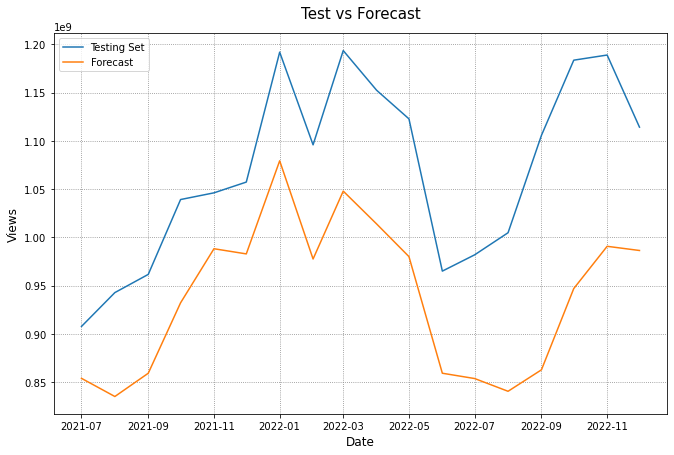

In [9]:
#train Cat Boost
traffic_df_copy = traffic_df.copy()
datetime_features(traffic_df_copy)
traffic_features = traffic_df_copy.loc[:, traffic_df_copy.columns != 'Views']
traffic_target = traffic_df_copy['Views']
train_traffic_features, test_traffic_features,\
train_traffic_target, test_traffic_target =\
                              traffic_features[:train_test_split_ratio], \
                              traffic_features[train_test_split_ratio:], \
                              traffic_target[:train_test_split_ratio], \
                              traffic_target[train_test_split_ratio:]
create_catboost(train_traffic_features, train_traffic_target,
               test_traffic_features, test_traffic_target, save=True)

17:15:18 - cmdstanpy - INFO - Chain [1] start processing
17:15:19 - cmdstanpy - INFO - Chain [1] done processing


MSE Error: [6.07088871e+16 4.98232948e+16 5.06569993e+16 2.05756559e+16
 1.12544031e+16 1.21129507e+16 8.31687495e+15 2.38904831e+16
 1.09884362e+16 1.89575309e+16 1.71447343e+16 5.35741276e+16
 7.02369955e+16 6.82466713e+16 5.23453928e+16 2.14904775e+16
 1.59662772e+16 1.67368979e+16]
RMSE Error: [2.46391735e+08 2.23211323e+08 2.25071098e+08 1.43442169e+08
 1.06086772e+08 1.10058851e+08 9.11969021e+07 1.54565466e+08
 1.04825742e+08 1.37686350e+08 1.30937903e+08 2.31460856e+08
 2.65022632e+08 2.61240639e+08 2.28791155e+08 1.46596308e+08
 1.26357735e+08 1.29371163e+08]
Mean: 933651128.5819662


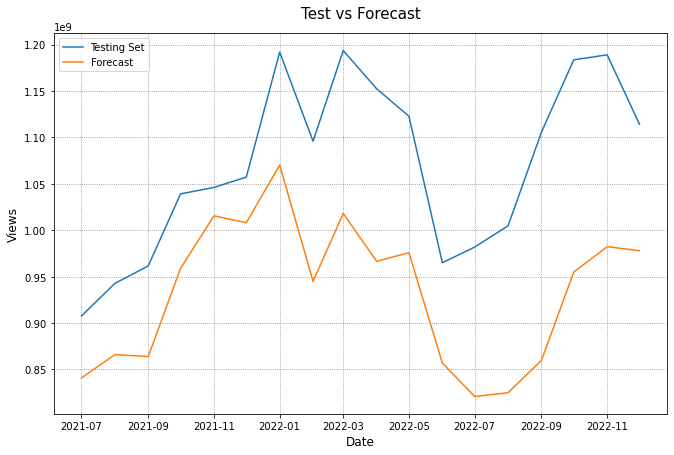

In [10]:
#train Prophet
train_traffic, test_traffic = traffic_df[:train_test_split_ratio],\
                              traffic_df[train_test_split_ratio:]
train_traffic.reset_index(inplace=True)
train_traffic.columns = ['ds', 'y']
create_prophet(train_traffic, test_traffic, save=True)